# Análise de Valorização Imobiliária Real por Tipo de Uso

Este notebook analisa a valorização real dos imóveis ao longo do tempo, calculando taxas de crescimento anual para diferentes tipos de uso em São Paulo.

**Objetivos principais:**
- Calcular taxa de valorização anual real para cada imóvel individual
- Identificar tipos de uso com maior e menor valorização
- Aplicar critérios estatísticos rigorosos para análise confiável
- Excluir outliers por tipo de uso usando método IQR
- Gerar análises temporais e comparativas por tipo de uso

**Metodologia:**
1. **Cálculo de Taxa de Valorização Individual**: Regressão linear no log dos valores venais ao longo do tempo para cada imóvel
2. **Critério de Significância**: Pelo menos 100 amostras em 4 dos 6 anos por tipo de uso
3. **Exclusão de Outliers**: Método IQR aplicado separadamente para cada tipo de uso
4. **Análise Estatística**: Testes de significância e correlações para validar resultados
5. **Agrupamento por Tipo**: Estatísticas agregadas e comparações entre tipos de uso

**Dados:**
- ITBI: Transações imobiliárias (2019-2024)
- IPTU: Valores venais estimados pela Prefeitura (2019-2024)

**Resultado**: Taxa de valorização anual real por tipo de uso do imóvel, não apenas divergências entre estimativas.


## 1. Importação de Bibliotecas


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Bibliotecas importadas com sucesso!')


✅ Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados


In [2]:
# Definir caminhos dos arquivos
data_path = 'data/'
iptu_file = data_path + 'IPTU_2019_2024.csv'
itbi_file = data_path + 'ITBI_2019_2024.csv'  # Versão com dados geográficos

print('Carregando dados...')
print(f'Arquivo IPTU: {iptu_file}')
print(f'Arquivo ITBI: {itbi_file}')

try:
    df_itbi = pd.read_csv(itbi_file, encoding='utf-8', low_memory=False)
    print(f'\\n✅ Dados ITBI carregados: {df_itbi.shape[0]:,} registros e {df_itbi.shape[1]} colunas')
    
    df_iptu = pd.read_csv(iptu_file, encoding='utf-8', low_memory=False)
    print(f'✅ Dados IPTU carregados: {df_iptu.shape[0]:,} registros e {df_iptu.shape[1]} colunas')
except Exception as e:
    print(f'Erro ao carregar: {e}')
    try:
        print('Tentando com encoding latin-1...')
        df_itbi = pd.read_csv(itbi_file, encoding='latin-1', low_memory=False)
        df_iptu = pd.read_csv(iptu_file, encoding='latin-1', low_memory=False)
        print(f'✅ Dados carregados com sucesso!')
    except:
        print('Erro ao carregar com diferentes encodings')

print('\\n🎉 Carregamento concluído!')


Carregando dados...
Arquivo IPTU: data/IPTU_2019_2024.csv
Arquivo ITBI: data/ITBI_2019_2024.csv
\n✅ Dados ITBI carregados: 908,503 registros e 20 colunas
Erro ao carregar: Error tokenizing data. C error: out of memory
Tentando com encoding latin-1...
✅ Dados carregados com sucesso!
\n🎉 Carregamento concluído!


## 3. Preparação dos Dados para Análise

Esta seção realiza:
1. **Filtros ITBI**: Apenas registros com `Proporção Transmitida (%) = 100%`
2. **Cálculo VALOR REAL**: Reversão da proporção transmitida para obter valor total
3. **Merge 1:N**: Junção de ITBI com IPTU usando número do cadastro + ano
4. **Preparação para análise temporal**: Dados organizados para cálculo de valorização por imóvel


In [3]:
# ============================================================================
# 3. PREPARAÇÃO DOS DADOS PARA ANÁLISE
# ============================================================================

print('='*80)
print('3. PREPARAÇÃO DOS DADOS PARA ANÁLISE'.center(80))
print('='*80)

# 3.1. Filtros e Preparação dos Dados ITBI
print('\n📋 3.1. FILTROS E PREPARAÇÃO DOS DADOS ITBI\n')

# Verificar colunas disponíveis
print('📋 Colunas disponíveis no ITBI:')
for i, col in enumerate(df_itbi.columns):
    print(f'   {i+1:2d}. {col}')

required_cols = ['Proporção Transmitida (%)', 'Base de Cálculo adotada', 
                 'N° do Cadastro (SQL)', 'Ano da Transacao']
if not all(col in df_itbi.columns for col in required_cols):
    print('❌ Colunas necessárias não encontradas!')
else:
    print('✅ Todas as colunas necessárias encontradas no ITBI')
    
    # Filtro 1: Proporção Transmitida (%) = 100
    print('\n🔹 Aplicando filtro: Proporção Transmitida (%) = 100...')
    count_before = len(df_itbi)
    df_itbi_filtered = df_itbi[df_itbi['Proporção Transmitida (%)'] == 100].copy()
    print(f'   Registros antes: {count_before:,}')
    print(f'   Registros após: {len(df_itbi_filtered):,}')
    print(f'   Registros removidos: {count_before - len(df_itbi_filtered):,} ({(count_before - len(df_itbi_filtered))/count_before*100:.2f}%)')
    
    # Cálculo VALOR REAL (quando proporção = 100, valor real = base de cálculo)
    print('\n🔹 Calculando VALOR REAL...')
    #df_itbi_filtered['VALOR REAL'] = df_itbi_filtered['Base de Cálculo adotada'].copy()
    df_itbi_filtered['VALOR REAL'] = df_itbi_filtered.apply(lambda row: row['Base de Cálculo adotada'] / row['Proporção Transmitida (%)'] * 100, axis=1)
    df_itbi_filtered = df_itbi_filtered[df_itbi_filtered['VALOR REAL'] > 1]
    
    # Verificar se existe coluna 'Valor Venal de Referência' para aplicar filtro adicional
    if 'Valor Venal de Referência' in df_itbi_filtered.columns:
        print('\n🔹 Aplicando filtro adicional: Valor Venal de Referência > 1...')
        count_before_venal = len(df_itbi_filtered)
        df_itbi_filtered = df_itbi_filtered[df_itbi_filtered['Valor Venal de Referência'] > 1].copy()
        print(f'   Registros antes: {count_before_venal:,}')
        print(f'   Registros após: {len(df_itbi_filtered):,}')
        print(f'   Registros removidos: {count_before_venal - len(df_itbi_filtered):,} ({(count_before_venal - len(df_itbi_filtered))/count_before_venal*100:.2f}%)')
    else:
        print('\n⚠️ Coluna "Valor Venal de Referência" não encontrada. Aplicando apenas filtro VALOR REAL > 1...')
    
    # Filtro 2: VALOR REAL > 1
    count_before_valor = len(df_itbi_filtered)
    df_itbi_filtered = df_itbi_filtered[df_itbi_filtered['VALOR REAL'] > 1].copy()
    print(f'\n   Registros antes: {count_before_valor:,}')
    print(f'   Registros após: {len(df_itbi_filtered):,}')
    
    # Estatísticas
    print(f'\n📊 ESTATÍSTICAS DO VALOR REAL:')
    print(f'   Total: {len(df_itbi_filtered):,}')
    print(f'   Mínimo: R$ {df_itbi_filtered["VALOR REAL"].min():,.2f}')
    print(f'   Máximo: R$ {df_itbi_filtered["VALOR REAL"].max():,.2f}')
    print(f'   Médio: R$ {df_itbi_filtered["VALOR REAL"].mean():,.2f}')
    print(f'   Mediano: R$ {df_itbi_filtered["VALOR REAL"].median():,.2f}')

# 3.2. Preparação IPTU
print('\n📋 3.2. PREPARAÇÃO DOS DADOS IPTU\n')

if 'VALOR VENAL' in df_iptu.columns:
    df_iptu['VALOR VENAL'] = pd.to_numeric(df_iptu['VALOR VENAL'], errors='coerce')
    df_iptu_filtered = df_iptu[df_iptu['VALOR VENAL'].notna() & (df_iptu['VALOR VENAL'] > 0)].copy()
    print('✅ VALOR VENAL processado')
    print(f'   Total: {len(df_iptu_filtered):,}')
    print(f'   Mínimo: R$ {df_iptu_filtered["VALOR VENAL"].min():,.2f}')
    print(f'   Máximo: R$ {df_iptu_filtered["VALOR VENAL"].max():,.2f}')
    print(f'   Médio: R$ {df_iptu_filtered["VALOR VENAL"].mean():,.2f}')
else:
    print('❌ VALOR VENAL não encontrado!')
    df_iptu_filtered = df_iptu.copy()

# 3.3. Merge 1:N
print('\n📋 3.3. REALIZAÇÃO DO MERGE 1:N\n')

# Converter para string
df_itbi_filtered['N° do Cadastro (SQL)'] = df_itbi_filtered['N° do Cadastro (SQL)'].astype(str)
df_itbi_filtered['Ano da Transacao'] = df_itbi_filtered['Ano da Transacao'].astype(str)

df_iptu_filtered['NUMERO DO CONTRIBUINTE'] = df_iptu_filtered['NUMERO DO CONTRIBUINTE'].astype(str)
df_iptu_filtered['ANO DO EXERCICIO'] = df_iptu_filtered['ANO DO EXERCICIO'].astype(str)

print('🔄 Realizando merge...')
print(f'   ITBI: {len(df_itbi_filtered):,}')
print(f'   IPTU: {len(df_iptu_filtered):,}')

df_merged = pd.merge(
    df_itbi_filtered,
    df_iptu_filtered,
    left_on=['N° do Cadastro (SQL)', 'Ano da Transacao'],
    right_on=['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO'],
    how='inner',
    suffixes=('_ITBI', '_IPTU')
)

print(f'\n✅ Merge: {len(df_merged):,} registros')

# Limpeza
df_merged_clean = df_merged[
    df_merged['VALOR REAL'].notna() & 
    df_merged['VALOR VENAL'].notna() &
    (df_merged['VALOR REAL'] > 0) &
    (df_merged['VALOR VENAL'] > 0)
].copy()

print(f'   Após limpeza: {len(df_merged_clean):,} registros')

print('\n' + '='*80)
print('✅ DATASET PREPARADO PARA ANÁLISE DE VALORIZAÇÃO!'.center(80))
print('='*80)


                      3. PREPARAÇÃO DOS DADOS PARA ANÁLISE                      

📋 3.1. FILTROS E PREPARAÇÃO DOS DADOS ITBI

📋 Colunas disponíveis no ITBI:
    1. NÂ° do Cadastro (SQL)
    2. Natureza de TransaÃ§Ã£o
    3. Valor de TransaÃ§Ã£o (declarado pelo contribuinte)
    4. Data de TransaÃ§Ã£o
    5. Valor Venal de ReferÃªncia
    6. ProporÃ§Ã£o Transmitida (%)
    7. Valor Venal de ReferÃªncia (proporcional)
    8. Base de CÃ¡lculo adotada
    9. Tipo de Financiamento
   10. Valor Financiado
   11. SituaÃ§Ã£o do SQL
   12. Ãrea do Terreno (m2)
   13. Ãrea ConstruÃ­da (m2)
   14. Ano da Transacao
   15. Mes da Transacao
   16. Ano/Mes da Transacao
   17. setor
   18. quadra
   19. lote
   20. bairro
❌ Colunas necessárias não encontradas!

📋 3.2. PREPARAÇÃO DOS DADOS IPTU

✅ VALOR VENAL processado
   Total: 21,317,311
   Mínimo: R$ 78.01
   Máximo: R$ 4,861,333,058.59
   Médio: R$ 437,341.05

📋 3.3. REALIZAÇÃO DO MERGE 1:N



NameError: name 'df_itbi_filtered' is not defined

In [ ]:
# Verificar estrutura dos dados preparados
print('📊 ESTRUTURA DOS DADOS PREPARADOS:')
print(f'Total de registros: {len(df_merged_clean):,}')
print(f'Imóveis únicos: {df_merged_clean["N° do Cadastro (SQL)"].nunique():,}')
print(f'Anos disponíveis: {sorted(df_merged_clean["Ano da Transacao"].unique())}')
print(f'Tipos de uso: {df_merged_clean["TIPO DE USO DO IMOVEL"].nunique()}')

# Mostrar primeiras linhas
print('\n📋 PRIMEIRAS LINHAS DO DATASET:')
display(df_merged_clean.head())

📊 ESTRUTURA DOS DADOS PREPARADOS:
Total de registros: 568,412
Imóveis únicos: 503,313
Anos disponíveis: ['2019', '2020', '2021', '2022', '2023', '2024']
Tipos de uso: 37

📋 PRIMEIRAS LINHAS DO DATASET:


,N° do Cadastro (SQL),Natureza de Transação,Valor de Transação (declarado pelo contribuinte),Data de Transação,Valor Venal de Referência,Proporção Transmitida (%),Valor Venal de Referência (proporcional),Base de Cálculo adotada,Tipo de Financiamento,Valor Financiado,Situação do SQL,Ano da Transacao,Mes da Transacao,Ano/Mes da Transacao,setor,quadra,lote,bairro,VALOR REAL,NUMERO DO CONTRIBUINTE,ANO DO EXERCICIO,NOME DE LOGRADOURO DO IMOVEL,NUMERO DO IMOVEL,AREA DO TERRENO,AREA CONSTRUIDA,AREA OCUPADA,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,TIPO DE USO DO IMOVEL,TIPO DE PADRAO DA CONSTRUCAO,VALOR VENAL
0,12310100659,1.Compra e venda,900000.00,2019-01-02,773836.0,100.0,773836.0,900000.0,1.Sistema Financeiro de Habitação,400000.00,Ativo Predial,2019,1,2019/01,123,101,65,JARDIM LEONOR,900000.0,12310100659,2019,R FRANCISCO PRETO,46.0,49139.0,246.0,35645.0,1629,1854,Apartamento em condomínio,Residencial vertical - padrão D,532585.651680
1,5528502403,1.Compra e venda,420000.00,2019-01-02,303832.0,100.0,303832.0,420000.0,1.Sistema Financeiro de Habitação,340721.07,Ativo Predial,2019,1,2019/01,55,285,240,VL FORMOSA,420000.0,5528502403,2019,R PRETORIA,437.0,5152.0,109.0,3862.0,1468,1607,Apartamento em condomínio,Residencial vertical - padrão C,215205.380546
2,29903601032,1.Compra e venda,650000.00,2019-01-03,459364.0,100.0,459364.0,650000.0,NaN,0.00,Ativo Predial,2019,1,2019/01,299,36,103,VILA OLIMPIA,650000.0,29903601032,2019,R MIN JESUINO CARDOSO,148.0,1886.0,98.0,1432.0,4969,2139,Apartamento em condomínio,Residencial vertical - padrão C,319984.188000
3,4201104559,1.Compra e venda,61765.36,2019-01-03,300840.0,100.0,300840.0,300840.0,NaN,0.00,Ativo Predial,2019,1,2019/01,42,11,455,SAUDE,300840.0,4201104559,2019,R AFONSO CELSO,171.0,1968.0,84.0,1521.0,2223,2139,Apartamento em condomínio,Residencial vertical - padrão C,206303.522216
4,2206602970,1.Compra e venda,965000.00,2019-01-03,575501.0,100.0,575501.0,965000.0,NaN,0.00,Ativo Predial,2019,1,2019/01,22,66,297,PERDIZES,965000.0,2206602970,2019,R COTOXO,637.0,1548.0,172.0,1548.0,2908,2139,Apartamento em condomínio,Residencial vertical - padrão C,392974.116036


## 4. Análise de Valorização Venal por Tipo de Uso (Baseada apenas em IPTU)

**Metodologia:**
- Utilizar **apenas** os dados do IPTU (`df_iptu_filtered`)
- Analisar a evolução do **valor venal** ao longo do tempo usando o **ano do exercício**
- Aplicar **regressão linear no log dos valores** para capturar crescimento exponencial
- Critério: imóveis com registros em **pelo menos 4 dos 6 anos** (2019-2024)
- Agrupar por **tipo de uso** do imóvel
- Calcular taxa média de valorização anual por tipo de uso

**Objetivo:** Identificar como diferentes tipos de uso do imóvel se valorizam ao longo do tempo, usando exclusivamente a evolução dos valores venais estimados pela Prefeitura.

**Vantagem desta abordagem:**
- Dados mais consistentes (mesma metodologia de avaliação em todos os anos)
- Cobertura muito maior (todos os imóveis do IPTU, não apenas os que tiveram transações)
- Evolução temporal direta do valor venal, sem necessidade de merge com ITBI


In [ ]:
# ============================================================================
# 4.4. VALORIZAÇÃO REAL POR TIPO DE USO - ANÁLISE BASEADA APENAS EM IPTU
# ============================================================================

print('='*80)
print('4.4. VALORIZAÇÃO REAL POR TIPO DE USO (BASEADA APENAS EM IPTU)'.center(80))
print('='*80)

import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PASSO 1: PREPARAR DADOS DO IPTU PARA ANÁLISE TEMPORAL
# ============================================================================

print('\n📊 PASSO 1: PREPARAÇÃO DOS DADOS DO IPTU PARA ANÁLISE TEMPORAL\n')

# Verificar se df_iptu_filtered existe e preparar dados
if 'df_iptu_filtered' not in globals():
    print('⚠️ df_iptu_filtered não encontrado. Preparando a partir de df_iptu...')
    if 'VALOR VENAL' in df_iptu.columns:
        df_iptu['VALOR VENAL'] = pd.to_numeric(df_iptu['VALOR VENAL'], errors='coerce')
        df_iptu_filtered = df_iptu[df_iptu['VALOR VENAL'].notna() & (df_iptu['VALOR VENAL'] > 0)].copy()
        print(f'✅ Dados IPTU preparados: {len(df_iptu_filtered):,} registros')
    else:
        print('❌ Coluna VALOR VENAL não encontrada no dataset IPTU!')
        raise ValueError('Coluna VALOR VENAL não encontrada')

# Criar dataset focado na evolução temporal por imóvel usando apenas IPTU
df_valorizacao_iptu = df_iptu_filtered.copy()

# Garantir que temos as colunas necessárias
required_cols = ['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO', 'VALOR VENAL']
missing_cols = [col for col in required_cols if col not in df_valorizacao_iptu.columns]
if missing_cols:
    print(f'❌ Colunas faltando: {missing_cols}')
    print(f'Colunas disponíveis: {list(df_valorizacao_iptu.columns)}')
    raise ValueError(f'Colunas necessárias não encontradas: {missing_cols}')

# Verificar se temos tipo de uso (pode ter nomes diferentes)
tipo_uso_cols = [col for col in df_valorizacao_iptu.columns if 'TIPO' in col.upper() and 'USO' in col.upper()]
if not tipo_uso_cols:
    print('⚠️ Coluna de tipo de uso não encontrada. Procurando alternativas...')
    print(f'Colunas disponíveis: {list(df_valorizacao_iptu.columns)}')
    tipo_uso_col = None
else:
    tipo_uso_col = tipo_uso_cols[0]
    print(f'✅ Coluna de tipo de uso encontrada: {tipo_uso_col}')

# Limpar dados
df_valorizacao_iptu = df_valorizacao_iptu[
    df_valorizacao_iptu['VALOR VENAL'].notna() & 
    (df_valorizacao_iptu['VALOR VENAL'] > 0) &
    df_valorizacao_iptu['ANO DO EXERCICIO'].notna()
].copy()

# Converter ano para numérico
df_valorizacao_iptu['ANO'] = pd.to_numeric(df_valorizacao_iptu['ANO DO EXERCICIO'], errors='coerce')
df_valorizacao_iptu = df_valorizacao_iptu[df_valorizacao_iptu['ANO'].notna()].copy()

# Verificar anos disponíveis
anos_disponiveis = sorted(df_valorizacao_iptu['ANO'].unique())
print(f'\n📅 Anos disponíveis: {anos_disponiveis}')
print(f'Total de registros: {len(df_valorizacao_iptu):,}')
print(f'Imóveis únicos: {df_valorizacao_iptu["NUMERO DO CONTRIBUINTE"].nunique():,}')

# Estatísticas gerais
print(f'\n📊 ESTATÍSTICAS DO VALOR VENAL:')
print(f'   Mínimo: R$ {df_valorizacao_iptu["VALOR VENAL"].min():,.2f}')
print(f'   Máximo: R$ {df_valorizacao_iptu["VALOR VENAL"].max():,.2f}')
print(f'   Médio: R$ {df_valorizacao_iptu["VALOR VENAL"].mean():,.2f}')
print(f'   Mediano: R$ {df_valorizacao_iptu["VALOR VENAL"].median():,.2f}')

# Contagem de registros por ano
print(f'\n📊 REGISTROS POR ANO:')
contagem_por_ano = df_valorizacao_iptu['ANO'].value_counts().sort_index()
for ano, count in contagem_por_ano.items():
    print(f'   {int(ano)}: {count:,} registros')


         4.4. VALORIZAÇÃO REAL POR TIPO DE USO (BASEADA APENAS EM IPTU)         

📊 PASSO 1: PREPARAÇÃO DOS DADOS DO IPTU PARA ANÁLISE TEMPORAL

✅ Coluna de tipo de uso encontrada: TIPO DE USO DO IMOVEL

📅 Anos disponíveis: [2019, 2020, 2021, 2022, 2023, 2024]
Total de registros: 21,317,311
Imóveis únicos: 3,759,687

📊 ESTATÍSTICAS DO VALOR VENAL:
   Mínimo: R$ 78.01
   Máximo: R$ 4,861,333,058.59
   Médio: R$ 437,341.05
   Mediano: R$ 209,142.38

📊 REGISTROS POR ANO:
   2019: 3,447,112 registros
   2020: 3,498,644 registros
   2021: 3,489,273 registros
   2022: 3,588,319 registros
   2023: 3,644,459 registros
   2024: 3,649,504 registros


In [ ]:
# ============================================================================
# PASSO 2: FILTRAR IMÓVEIS COM PELO MENOS 4 DOS 6 ANOS DE DADOS
# ============================================================================

print('\n📋 PASSO 2: FILTRO DE IMÓVEIS COM PELO MENOS 4 ANOS DE DADOS\n')

# Contar quantos anos cada imóvel tem dados
contagem_anos_por_imovel = df_valorizacao_iptu.groupby('NUMERO DO CONTRIBUINTE')['ANO'].nunique()
print(f'Distribuição de anos por imóvel:')
print(contagem_anos_por_imovel.value_counts().sort_index())

# Filtrar: pelo menos 4 anos de dados
imoveis_com_4_anos = contagem_anos_por_imovel[contagem_anos_por_imovel >= 4].index
df_valorizacao_iptu_filtrado = df_valorizacao_iptu[
    df_valorizacao_iptu['NUMERO DO CONTRIBUINTE'].isin(imoveis_com_4_anos)
].copy()

print(f'\n✅ FILTRO APLICADO:')
print(f'   Imóveis antes do filtro: {df_valorizacao_iptu["NUMERO DO CONTRIBUINTE"].nunique():,}')
print(f'   Imóveis após filtro (>=4 anos): {len(imoveis_com_4_anos):,}')
print(f'   Registros antes do filtro: {len(df_valorizacao_iptu):,}')
print(f'   Registros após filtro: {len(df_valorizacao_iptu_filtrado):,}')
print(f'   Redução: {(1 - len(df_valorizacao_iptu_filtrado)/len(df_valorizacao_iptu))*100:.2f}%')

# Verificar distribuição de anos após filtro
print(f'\n📊 DISTRIBUIÇÃO DE ANOS APÓS FILTRO:')
contagem_anos_apos = df_valorizacao_iptu_filtrado.groupby('NUMERO DO CONTRIBUINTE')['ANO'].nunique()
print(contagem_anos_apos.value_counts().sort_index())



📋 PASSO 2: FILTRO DE IMÓVEIS COM PELO MENOS 4 ANOS DE DADOS

Distribuição de anos por imóvel:
ANO
1      99368
2      70341
3      64394
4      49903
5     169619
6    3306062
Name: count, dtype: int64

✅ FILTRO APLICADO:
   Imóveis antes do filtro: 3,759,687
   Imóveis após filtro (>=4 anos): 3,525,584
   Registros antes do filtro: 21,317,311
   Registros após filtro: 20,884,079
   Redução: 2.03%

📊 DISTRIBUIÇÃO DE ANOS APÓS FILTRO:
ANO
4      49903
5     169619
6    3306062
Name: count, dtype: int64



📈 PASSO 3: CÁLCULO DA TAXA DE VALORIZAÇÃO POR IMÓVEL

Aplicando regressão linear no log dos valores para capturar crescimento exponencial...
Calculando taxa de valorização para cada imóvel...
   Processados 50,000 / 3,525,584 imóveis (1.4%)
   Processados 100,000 / 3,525,584 imóveis (2.8%)
   Processados 150,000 / 3,525,584 imóveis (4.3%)
   Processados 200,000 / 3,525,584 imóveis (5.7%)
   Processados 250,000 / 3,525,584 imóveis (7.1%)
   Processados 300,000 / 3,525,584 imóveis (8.5%)
   Processados 350,000 / 3,525,584 imóveis (9.9%)
   Processados 400,000 / 3,525,584 imóveis (11.3%)
   Processados 450,000 / 3,525,584 imóveis (12.8%)
   Processados 500,000 / 3,525,584 imóveis (14.2%)
   Processados 550,000 / 3,525,584 imóveis (15.6%)
   Processados 600,000 / 3,525,584 imóveis (17.0%)
   Processados 650,000 / 3,525,584 imóveis (18.4%)
   Processados 700,000 / 3,525,584 imóveis (19.9%)
   Processados 750,000 / 3,525,584 imóveis (21.3%)
   Processados 800,000 / 3,525,584 imóveis (22.7%)

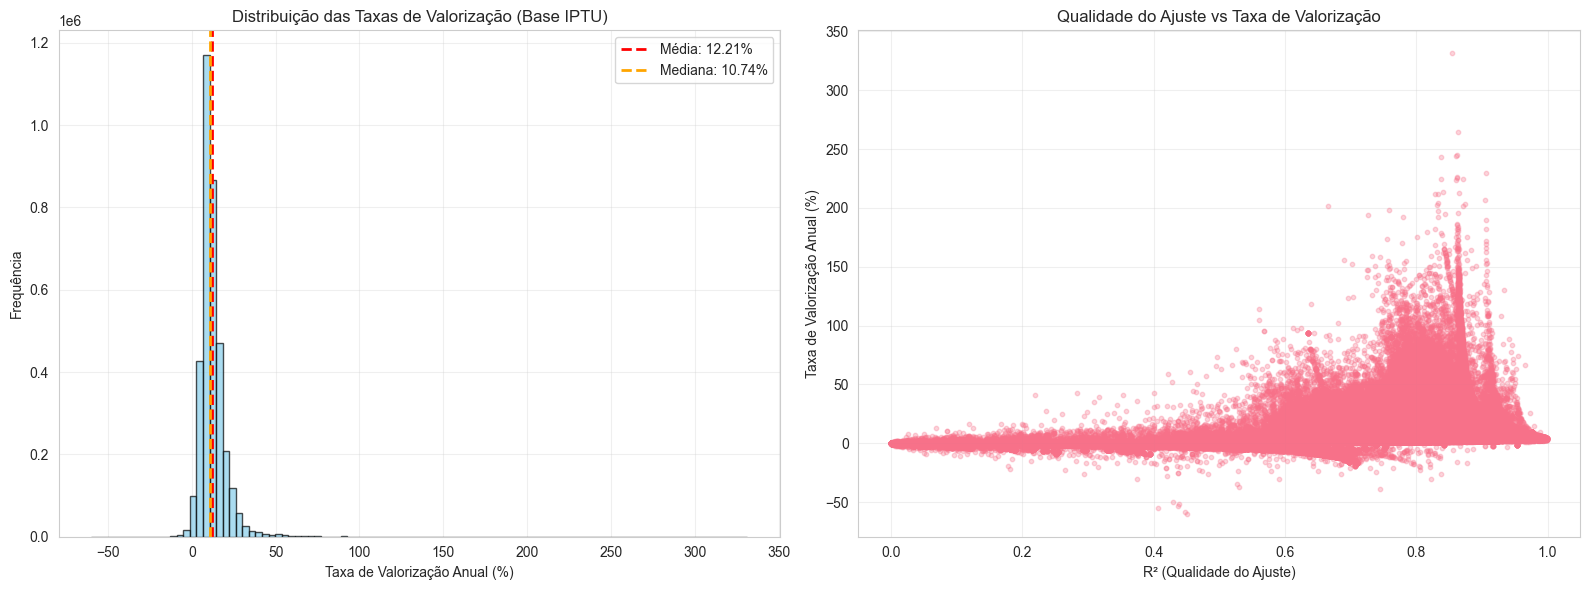

In [ ]:
# ============================================================================
# PASSO 3: CALCULAR TAXA DE VALORIZAÇÃO POR IMÓVEL (REGRESSÃO LINEAR NO LOG)
# ============================================================================

print('\n📈 PASSO 3: CÁLCULO DA TAXA DE VALORIZAÇÃO POR IMÓVEL\n')
print('Aplicando regressão linear no log dos valores para capturar crescimento exponencial...')

def calcular_taxa_valorizacao_iptu(group):
    """
    Calcula a taxa de valorização anual para um imóvel específico
    usando regressão linear no log dos valores venais ao longo do tempo
    
    Metodologia:
    - log(V(t)) = a + b*t, onde t é o ano
    - Taxa anual = (exp(b) - 1) * 100
    """
    if len(group) < 2:  # Precisa de pelo menos 2 pontos
        return None
    
    # Ordenar por ano
    group_sorted = group.sort_values('ANO')
    
    # Usar valor venal
    anos = group_sorted['ANO'].values.astype(int)
    valores = group_sorted['VALOR VENAL'].values
    
    # Filtrar valores válidos
    mask = (valores > 0) & (~np.isnan(valores))
    if np.sum(mask) < 2:
        return None
    
    anos_validos = anos[mask]
    valores_validos = valores[mask]
    
    # Verificar se tem pelo menos 4 anos
    anos_unicos = len(set(anos_validos))
    if anos_unicos < 4:
        return None
    
    # Calcular taxa de crescimento usando regressão linear no log
    try:
        # Log dos valores para crescimento exponencial
        log_valores = np.log(valores_validos)
        
        # Regressão linear: log(valor) = intercept + slope*ano
        slope, intercept, r_value, p_value, std_err = stats.linregress(anos_validos, log_valores)
        
        # Taxa de crescimento anual (em %)
        # Se log(V) = a + b*t, então V = exp(a) * exp(b)^t
        # Taxa anual = exp(b) - 1
        taxa_anual = (np.exp(slope) - 1) * 100
        
        # Adicionar tipo de uso se disponível
        tipo_uso = group_sorted[tipo_uso_col].iloc[0] if tipo_uso_col else None
        
        return {
            'cadastro': group_sorted['NUMERO DO CONTRIBUINTE'].iloc[0],
            'tipo_uso': tipo_uso,
            'taxa_valorizacao_anual': taxa_anual,
            'r_squared': r_value**2,
            'p_value': p_value,
            'num_observacoes': len(anos_validos),
            'anos_cobertos': anos_unicos,
            'anos_min': int(min(anos_validos)),
            'anos_max': int(max(anos_validos)),
            'valor_inicial': valores_validos[0],
            'valor_final': valores_validos[-1],
            'slope': slope,
            'intercept': intercept
        }
    except Exception as e:
        return None

# Aplicar função para cada imóvel
print('Calculando taxa de valorização para cada imóvel...')
resultados_valorizacao_iptu = []

total_imoveis = df_valorizacao_iptu_filtrado['NUMERO DO CONTRIBUINTE'].nunique()
for idx, (cadastro, group) in enumerate(df_valorizacao_iptu_filtrado.groupby('NUMERO DO CONTRIBUINTE')):
    if (idx + 1) % 50000 == 0:
        print(f'   Processados {idx + 1:,} / {total_imoveis:,} imóveis ({100*(idx+1)/total_imoveis:.1f}%)')
    
    resultado = calcular_taxa_valorizacao_iptu(group)
    if resultado is not None:
        resultados_valorizacao_iptu.append(resultado)

# Converter para DataFrame
df_taxas_valorizacao_iptu = pd.DataFrame(resultados_valorizacao_iptu)

print(f'\n✅ Taxas calculadas para {len(df_taxas_valorizacao_iptu):,} imóveis')

# Estatísticas gerais das taxas
if len(df_taxas_valorizacao_iptu) > 0:
    print(f'\n📊 ESTATÍSTICAS DAS TAXAS DE VALORIZAÇÃO:')
    print(f'   Taxa média: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].mean():.2f}% ao ano')
    print(f'   Taxa mediana: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].median():.2f}% ao ano')
    print(f'   Desvio padrão: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].std():.2f}%')
    print(f'   Mínimo: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].min():.2f}%')
    print(f'   Máximo: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].max():.2f}%')
    print(f'   R² médio: {df_taxas_valorizacao_iptu["r_squared"].mean():.3f}')
    print(f'   Anos cobertos médio: {df_taxas_valorizacao_iptu["anos_cobertos"].mean():.1f}')
    
    # Visualização das taxas gerais
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histograma das taxas
    axes[0].hist(df_taxas_valorizacao_iptu['taxa_valorizacao_anual'], bins=100, 
                 color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(df_taxas_valorizacao_iptu['taxa_valorizacao_anual'].mean(), 
                    color='red', linestyle='--', linewidth=2, 
                    label=f'Média: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].mean():.2f}%')
    axes[0].axvline(df_taxas_valorizacao_iptu['taxa_valorizacao_anual'].median(), 
                    color='orange', linestyle='--', linewidth=2, 
                    label=f'Mediana: {df_taxas_valorizacao_iptu["taxa_valorizacao_anual"].median():.2f}%')
    axes[0].set_xlabel('Taxa de Valorização Anual (%)')
    axes[0].set_ylabel('Frequência')
    axes[0].set_title('Distribuição das Taxas de Valorização (Base IPTU)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot: R² vs Taxa
    axes[1].scatter(df_taxas_valorizacao_iptu['r_squared'], 
                    df_taxas_valorizacao_iptu['taxa_valorizacao_anual'], 
                    alpha=0.3, s=10)
    axes[1].set_xlabel('R² (Qualidade do Ajuste)')
    axes[1].set_ylabel('Taxa de Valorização Anual (%)')
    axes[1].set_title('Qualidade do Ajuste vs Taxa de Valorização')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dados_processados/taxas_valorizacao_iptu_geral.png', dpi=300, bbox_inches='tight')
    print('\n💾 Gráfico salvo em: dados_processados/taxas_valorizacao_iptu_geral.png')
    plt.show()
else:
    print('⚠️ Nenhuma taxa foi calculada. Verifique os dados.')


In [ ]:
# ============================================================================
# PASSO 4: ANÁLISE POR TIPO DE USO (se disponível)
# ============================================================================

if tipo_uso_col and len(df_taxas_valorizacao_iptu) > 0 and 'tipo_uso' in df_taxas_valorizacao_iptu.columns:
    print('\n📊 PASSO 4: ANÁLISE POR TIPO DE USO\n')
    
    # Remover registros sem tipo de uso
    df_taxas_com_tipo = df_taxas_valorizacao_iptu[
        df_taxas_valorizacao_iptu['tipo_uso'].notna()
    ].copy()
    
    print(f'Imóveis com tipo de uso identificado: {len(df_taxas_com_tipo):,}')
    print(f'Tipos de uso únicos: {df_taxas_com_tipo["tipo_uso"].nunique()}')
    
    # Contar amostras por tipo de uso
    contagem_por_tipo = df_taxas_com_tipo['tipo_uso'].value_counts()
    print(f'\n📈 TOP 10 TIPOS DE USO POR VOLUME:')
    for i, (tipo, count) in enumerate(contagem_por_tipo.head(10).items(), 1):
        print(f'   {i:2d}. {tipo}: {count:,} imóveis')
    
    # ============================================================================
    # PASSO 5: EXCLUSÃO DE OUTLIERS POR TIPO DE USO (MÉTODO IQR)
    # ============================================================================
    
    print('\n🚨 PASSO 5: EXCLUSÃO DE OUTLIERS POR TIPO DE USO (IQR)\n')
    
    def remover_outliers_por_tipo_iqr(df, coluna_taxa='taxa_valorizacao_anual', coluna_tipo='tipo_uso'):
        """Remove outliers usando método IQR para cada tipo de uso separadamente"""
        df_limpo = df.copy()
        outliers_removidos = 0
        
        tipos_processados = 0
        for tipo in df[coluna_tipo].unique():
            mask_tipo = df[coluna_tipo] == tipo
            dados_tipo = df[mask_tipo][coluna_taxa]
            
            if len(dados_tipo) < 100:  # Pular tipos com poucos dados
                continue
                
            tipos_processados += 1
            # Calcular IQR
            Q1 = dados_tipo.quantile(0.25)
            Q3 = dados_tipo.quantile(0.75)
            IQR = Q3 - Q1
            
            # Limites para outliers
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            
            # Identificar outliers
            outliers_tipo = (dados_tipo < limite_inferior) | (dados_tipo > limite_superior)
            num_outliers = outliers_tipo.sum()
            
            if num_outliers > 0:
                if tipos_processados <= 20:  # Mostrar apenas primeiros 20 para não poluir output
                    print(f'   {tipo[:50]}: {num_outliers} outliers removidos (limites: {limite_inferior:.2f}% a {limite_superior:.2f}%)')
                outliers_removidos += num_outliers
                
                # Remover outliers
                indices_outliers = dados_tipo[outliers_tipo].index
                df_limpo = df_limpo.drop(indices_outliers)
        
        if tipos_processados > 20:
            print(f'   ... (mostrados apenas primeiros 20 tipos de uso)')
        
        print(f'\n✅ Total de outliers removidos: {outliers_removidos:,}')
        print(f'   Registros restantes: {len(df_limpo):,}')
        print(f'   Tipos de uso processados: {tipos_processados}')
        
        return df_limpo
    
    # Aplicar remoção de outliers
    df_taxas_iptu_limpas = remover_outliers_por_tipo_iqr(df_taxas_com_tipo)
    
    # Estatísticas após limpeza
    print(f'\n📊 ESTATÍSTICAS APÓS LIMPEZA:')
    print(f'   Taxa média: {df_taxas_iptu_limpas["taxa_valorizacao_anual"].mean():.2f}% ao ano')
    print(f'   Taxa mediana: {df_taxas_iptu_limpas["taxa_valorizacao_anual"].median():.2f}% ao ano')
    print(f'   Desvio padrão: {df_taxas_iptu_limpas["taxa_valorizacao_anual"].std():.2f}%')
    
    # ============================================================================
    # PASSO 6: ESTATÍSTICAS AGREGADAS POR TIPO DE USO
    # ============================================================================
    
    print('\n📊 PASSO 6: ESTATÍSTICAS AGREGADAS POR TIPO DE USO\n')
    
    # Calcular estatísticas agregadas por tipo de uso
    stats_por_tipo_iptu = df_taxas_iptu_limpas.groupby('tipo_uso').agg({
        'taxa_valorizacao_anual': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'r_squared': 'mean',
        'num_observacoes': 'mean',
        'anos_cobertos': 'mean'
    }).round(3)
    
    # Flatten das colunas multi-index
    stats_por_tipo_iptu.columns = ['Count', 'Taxa_Media', 'Taxa_Mediana', 'Taxa_Std', 
                                   'Taxa_Min', 'Taxa_Max', 'R2_Medio', 'Obs_Media', 'Anos_Cobertos']
    
    # Ordenar por taxa média
    stats_por_tipo_iptu = stats_por_tipo_iptu.sort_values('Taxa_Media', ascending=False)
    
    print(f'📈 ANÁLISE POR TIPO DE USO:')
    print(f'   Tipos analisados: {len(stats_por_tipo_iptu)}')
    print(f'   Total de imóveis: {stats_por_tipo_iptu["Count"].sum():,}')
    
    # Mostrar top 15 tipos com maior valorização
    print(f'\n🔝 TOP 15 TIPOS COM MAIOR VALORIZAÇÃO:')
    display(stats_por_tipo_iptu.head(15)[['Count', 'Taxa_Media', 'Taxa_Mediana', 'R2_Medio']])
    
    # Mostrar top 15 tipos com menor valorização
    print(f'\n🔻 TOP 15 TIPOS COM MENOR VALORIZAÇÃO:')
    display(stats_por_tipo_iptu.tail(15)[['Count', 'Taxa_Media', 'Taxa_Mediana', 'R2_Medio']])
    
else:
    print('\n⚠️ Análise por tipo de uso não disponível.')
    print('   Motivos possíveis:')
    print('   - Coluna de tipo de uso não encontrada no dataset IPTU')
    print('   - Nenhuma taxa foi calculada')
    if tipo_uso_col:
        print(f'   - Tipo de uso encontrado: {tipo_uso_col}')



📊 PASSO 4: ANÁLISE POR TIPO DE USO

Imóveis com tipo de uso identificado: 3,525,584
Tipos de uso únicos: 36

📈 TOP 10 TIPOS DE USO POR VOLUME:
    1. Apartamento em condomínio: 1,390,102 imóveis
    2. Residência: 1,083,952 imóveis
    3. Residência coletiva, exclusive cortiço (mais de uma residência no lote): 202,478 imóveis
    4. Garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial: 198,143 imóveis
    5. Escritório/consultório em condomínio (unidade autônoma): 140,250 imóveis
    6. Terreno: 107,772 imóveis
    7. Residência e outro uso (predominância residencial): 85,071 imóveis
    8. Loja: 53,748 imóveis
    9. Loja e residência (predominância comercial): 44,962 imóveis
   10. Garagem (unidade autônoma) em edifício em condomínio de escritórios, consultórios ou misto: 38,320 imóveis

🚨 PASSO 5: EXCLUSÃO DE OUTLIERS POR TIPO DE USO (IQR)

   Residência coletiva, exclusive cortiço (mais de um: 7552 outliers removidos (limites: -1.40% a 28.95%)
   

,Count,Taxa_Media,Taxa_Mediana,R2_Medio
tipo_uso,,,,
Terreno,103913,23.003,19.069,0.819
Garagem (exclusive em prédio em condomínio),2543,13.828,13.580,0.842
Cortiço,1683,13.792,13.782,0.831
Residência e outro uso (predominância residencial),81867,13.727,13.348,0.822
"Residência coletiva, exclusive cortiço (mais de uma residência no lote)",194926,13.680,13.191,0.826
Oficina,9466,13.625,13.223,0.840
Residência,1039756,13.424,12.872,0.830
Armazéns gerais e depósitos,8110,13.395,12.878,0.839
"Outras edificações de uso de serviço, com utilização múltipla",4666,13.029,12.719,0.842



🔻 TOP 15 TIPOS COM MENOR VALORIZAÇÃO:


,Count,Taxa_Media,Taxa_Mediana,R2_Medio
tipo_uso,,,,
Clube esportivo,529,10.401,9.944,0.835
Templo,5524,10.348,9.878,0.846
"Prédio de apartamento, não em condomínio, de uso exclusivamente residencial",1732,10.280,10.496,0.823
Flat residencial em condomínio,4627,9.995,10.341,0.846
"Prédio de escritório, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios) com ou sem loja (predominância comercial)",266,9.950,9.629,0.831
Apartamento em condomínio,1308681,9.849,9.397,0.833
"Prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)",2633,9.826,9.363,0.823
"Cinema, teatro, casa de diversão, clube ou congênere",539,9.354,9.254,0.836
Loja em edifício em condomínio (unidade autônoma),23335,8.739,8.439,0.819



📊 PASSO 7: VISUALIZAÇÕES FINAIS

💾 Gráfico principal salvo em: dados_processados/valorizacao_por_tipo_iptu_final.png


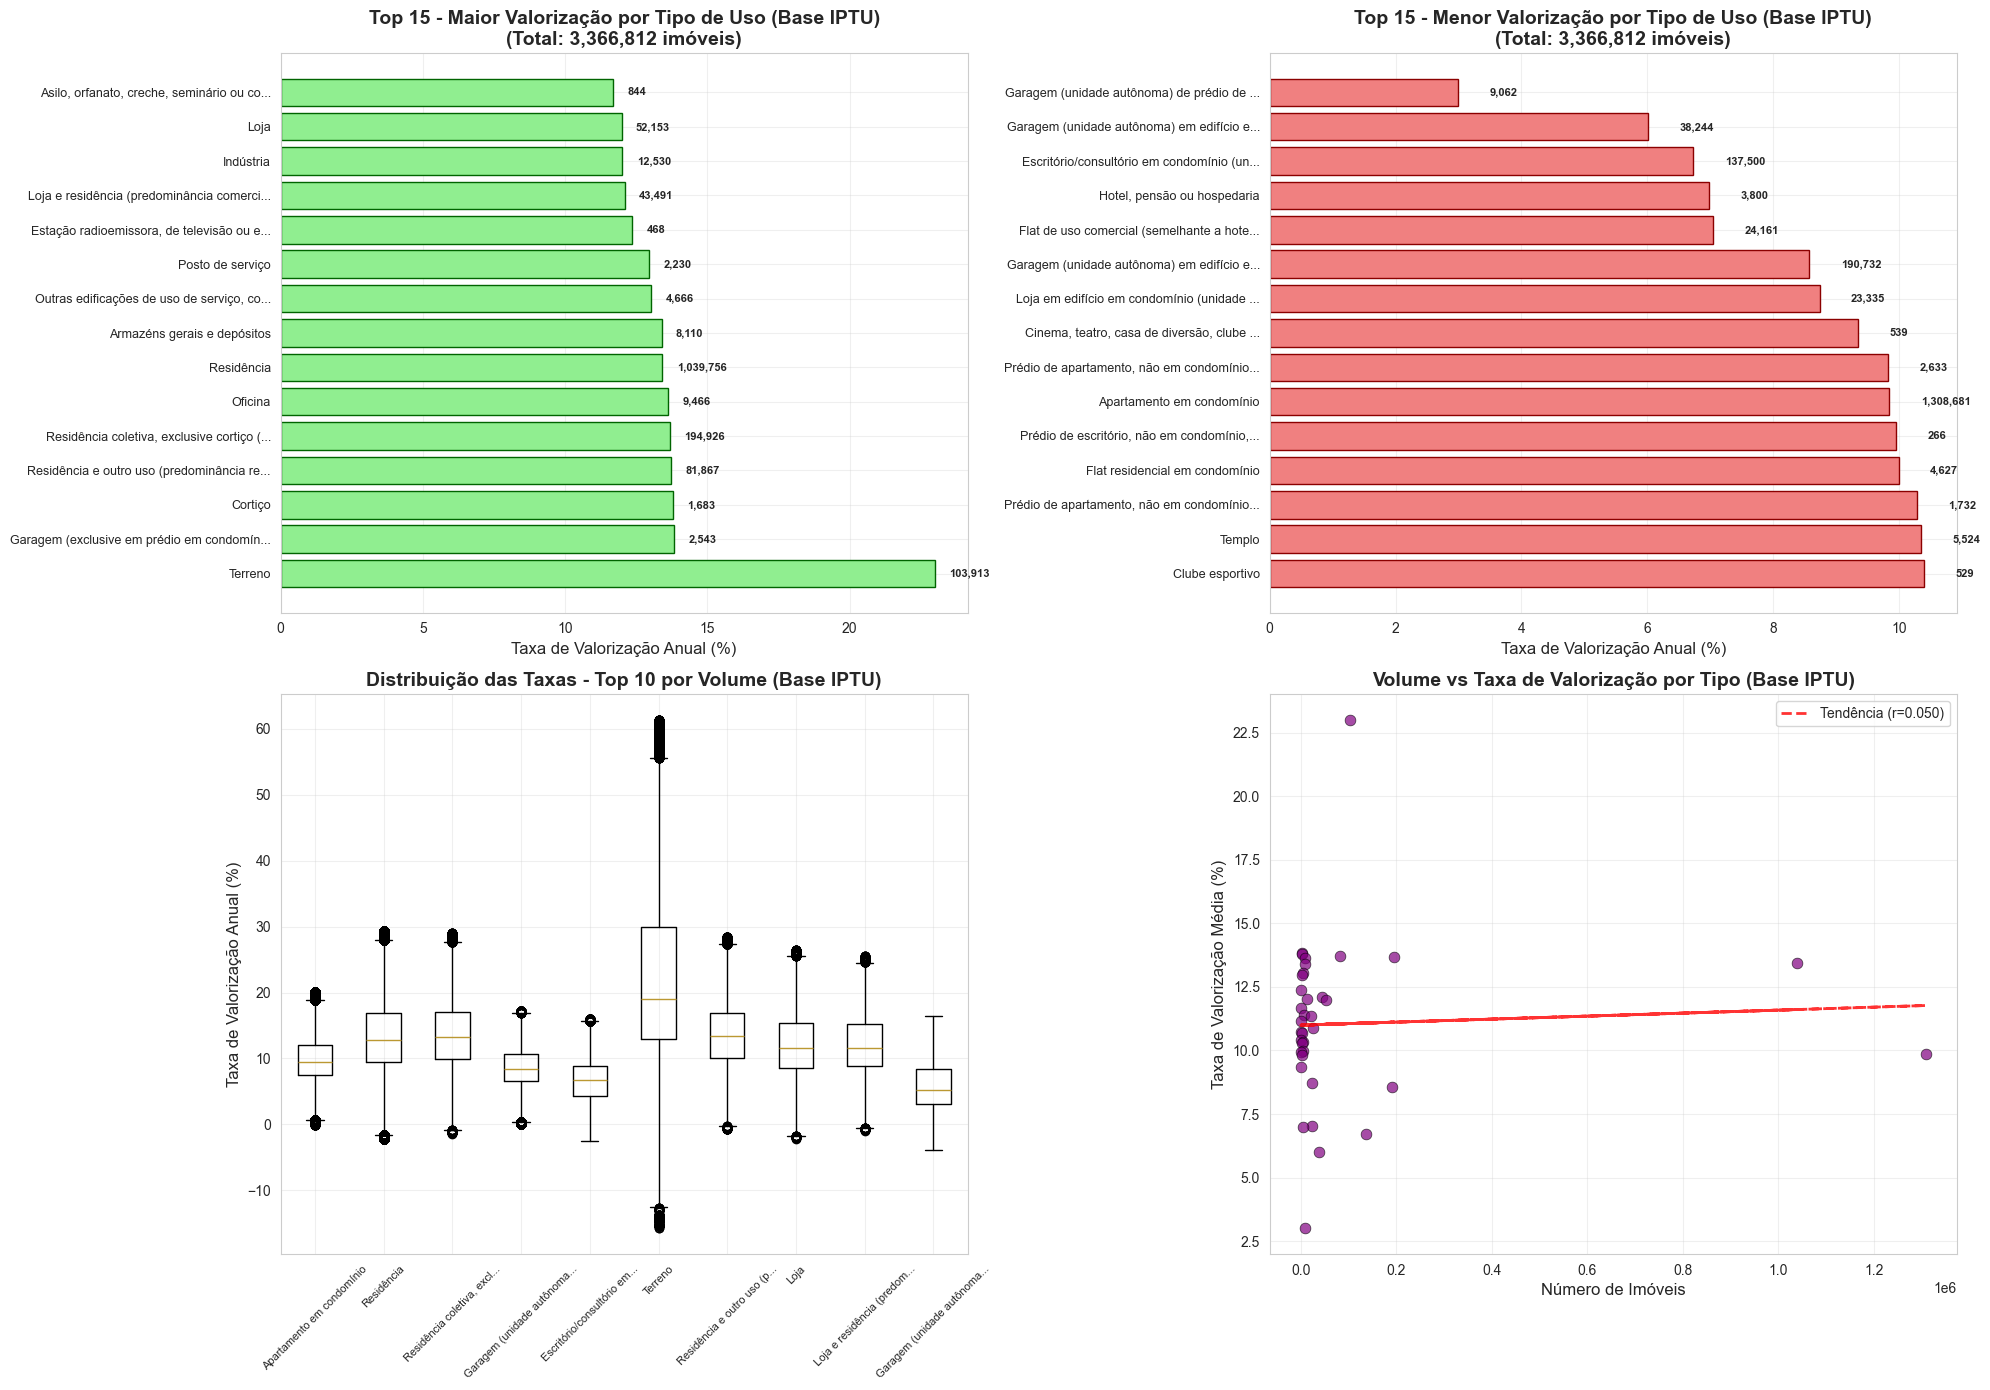


📅 Criando análise temporal dos top 10 tipos...
💾 Gráfico temporal salvo em: dados_processados/evolucao_temporal_valorizacao_iptu.png


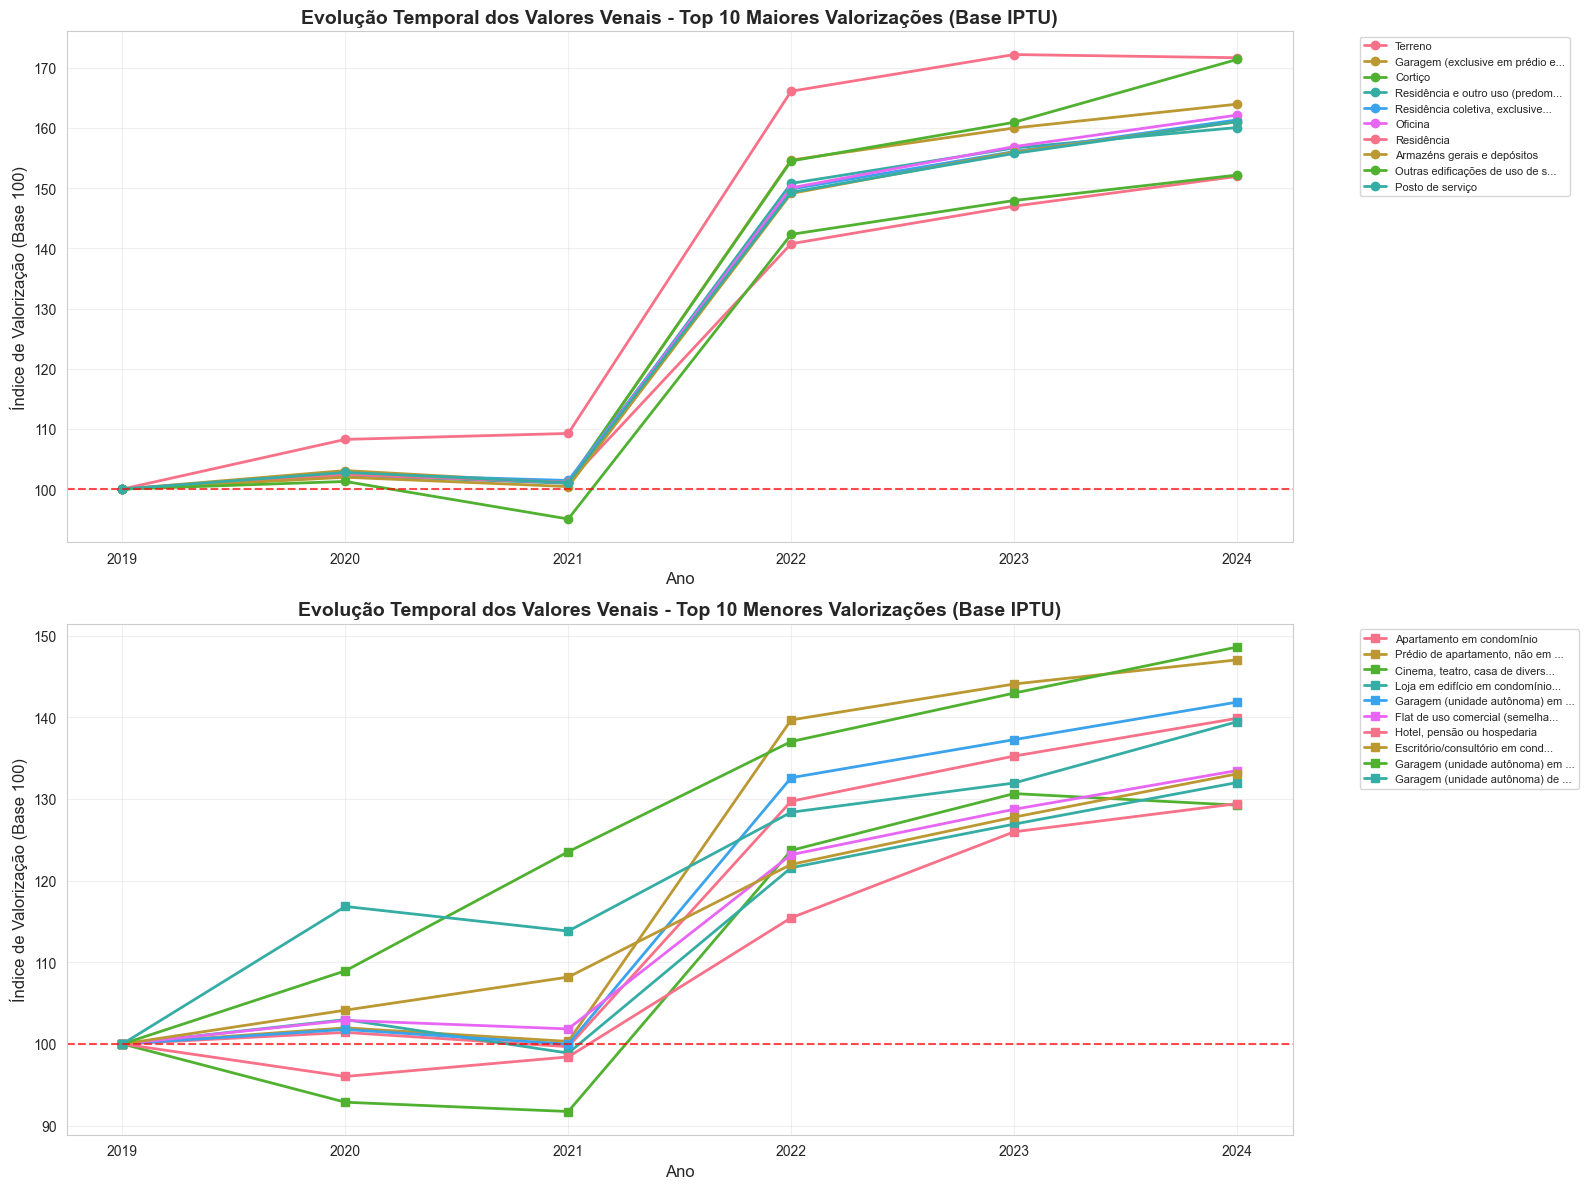


            📊 RESUMO FINAL - VALORIZAÇÃO POR TIPO DE USO (BASE IPTU)            

🎯 METODOLOGIA IMPLEMENTADA:
   ✅ Dados utilizados: Apenas IPTU (valor venal e ano do exercício)
   ✅ Taxa de valorização calculada por imóvel individual
   ✅ Regressão linear no log dos valores (crescimento exponencial)
   ✅ Critério aplicado: pelo menos 4 dos 6 anos de dados por imóvel
   ✅ Outliers removidos por tipo de uso (método IQR)
   ✅ Análise agrupada por tipo de uso

📈 RESULTADOS PRINCIPAIS:
   • Total de imóveis no IPTU: 3,759,687
   • Imóveis com >=4 anos: 3,525,584
   • Imóveis com taxa calculada: 3,525,584
   • Imóveis após remoção de outliers: 3,366,812
   • Tipos de uso analisados: 36
   • Taxa média geral: 11.51% ao ano
   • Taxa mediana geral: 10.54% ao ano

🔝 TOP 5 MAIORES VALORIZAÇÕES:
   1. Terreno: 23.00% ao ano (103,913 imóveis)
   2. Garagem (exclusive em prédio em condomínio): 13.83% ao ano (2,543 imóveis)
   3. Cortiço: 13.79% ao ano (1,683 imóveis)
   4. Residência e outro uso 

In [ ]:
# ============================================================================
# PASSO 7: VISUALIZAÇÕES FINAIS (se temos análise por tipo de uso)
# ============================================================================

if 'stats_por_tipo_iptu' in locals() and len(stats_por_tipo_iptu) > 0:
    print('\n📊 PASSO 7: VISUALIZAÇÕES FINAIS\n')
    
    # ============================================================================
    # VISUALIZAÇÃO 1: TOP 15 MAIORES E MENORES VALORIZAÇÕES
    # ============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Top 15 maiores valorizações
    top_15_maior = stats_por_tipo_iptu.head(15)
    bars1 = axes[0,0].barh(range(len(top_15_maior)), top_15_maior['Taxa_Media'], 
                           color='lightgreen', edgecolor='darkgreen', linewidth=1)
    axes[0,0].set_yticks(range(len(top_15_maior)))
    axes[0,0].set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                               for name in top_15_maior.index], fontsize=9)
    axes[0,0].set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
    axes[0,0].set_title(f'Top 15 - Maior Valorização por Tipo de Uso (Base IPTU)\n(Total: {len(df_taxas_iptu_limpas):,} imóveis)', 
                       fontsize=14, fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    
    # Adicionar número de imóveis nas barras
    for i, (bar, count) in enumerate(zip(bars1, top_15_maior['Count'])):
        axes[0,0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                      f'{int(count):,}', ha='left', va='center', fontsize=8, fontweight='bold')
    
    # Top 15 menores valorizações
    top_15_menor = stats_por_tipo_iptu.tail(15)
    bars2 = axes[0,1].barh(range(len(top_15_menor)), top_15_menor['Taxa_Media'], 
                           color='lightcoral', edgecolor='darkred', linewidth=1)
    axes[0,1].set_yticks(range(len(top_15_menor)))
    axes[0,1].set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                               for name in top_15_menor.index], fontsize=9)
    axes[0,1].set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
    axes[0,1].set_title(f'Top 15 - Menor Valorização por Tipo de Uso (Base IPTU)\n(Total: {len(df_taxas_iptu_limpas):,} imóveis)', 
                       fontsize=14, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # Adicionar número de imóveis nas barras
    for i, (bar, count) in enumerate(zip(bars2, top_15_menor['Count'])):
        axes[0,1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                      f'{int(count):,}', ha='left', va='center', fontsize=8, fontweight='bold')
    
    # Box plot das taxas por tipo (top 10 por volume)
    top_10_volume = stats_por_tipo_iptu.nlargest(10, 'Count')
    tipos_top_volume = top_10_volume.index.tolist()
    dados_boxplot = [df_taxas_iptu_limpas[df_taxas_iptu_limpas['tipo_uso'] == tipo]['taxa_valorizacao_anual'].values 
                     for tipo in tipos_top_volume]
    
    axes[1,0].boxplot(dados_boxplot, labels=[name[:25] + '...' if len(name) > 25 else name 
                                            for name in tipos_top_volume])
    axes[1,0].set_ylabel('Taxa de Valorização Anual (%)', fontsize=12)
    axes[1,0].set_title('Distribuição das Taxas - Top 10 por Volume (Base IPTU)', fontsize=14, fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1,0].grid(True, alpha=0.3)
    
    # Scatter plot: Volume vs Taxa de Valorização
    axes[1,1].scatter(stats_por_tipo_iptu['Count'], stats_por_tipo_iptu['Taxa_Media'], 
                      s=60, alpha=0.7, color='purple', edgecolors='black', linewidth=0.5)
    axes[1,1].set_xlabel('Número de Imóveis', fontsize=12)
    axes[1,1].set_ylabel('Taxa de Valorização Média (%)', fontsize=12)
    axes[1,1].set_title('Volume vs Taxa de Valorização por Tipo (Base IPTU)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    # Adicionar linha de tendência
    z = np.polyfit(stats_por_tipo_iptu['Count'], stats_por_tipo_iptu['Taxa_Media'], 1)
    p = np.poly1d(z)
    correlacao = stats_por_tipo_iptu['Count'].corr(stats_por_tipo_iptu['Taxa_Media'])
    axes[1,1].plot(stats_por_tipo_iptu['Count'], p(stats_por_tipo_iptu['Count']), 
                   "r--", alpha=0.8, linewidth=2, 
                   label=f'Tendência (r={correlacao:.3f})')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.savefig('dados_processados/valorizacao_por_tipo_iptu_final.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico principal salvo em: dados_processados/valorizacao_por_tipo_iptu_final.png')
    plt.show()
    
    # ============================================================================
    # VISUALIZAÇÃO 2: ANÁLISE TEMPORAL DOS TOP 10 TIPOS
    # ============================================================================
    
    print('\n📅 Criando análise temporal dos top 10 tipos...')
    
    # Selecionar top 10 tipos por taxa de valorização
    top_10_tipos_valorizacao = stats_por_tipo_iptu.head(10).index.tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Evolução temporal dos valores venais para top 10 tipos
    for i, tipo in enumerate(top_10_tipos_valorizacao):
        # Filtrar dados do tipo específico
        dados_tipo = df_valorizacao_iptu_filtrado[
            df_valorizacao_iptu_filtrado[tipo_uso_col] == tipo
        ]
        
        # Pegar imóveis deste tipo que têm taxa calculada
        cadastros_tipo = df_taxas_iptu_limpas[
            df_taxas_iptu_limpas['tipo_uso'] == tipo
        ]['cadastro'].unique()
        
        dados_tipo_filtrado = dados_tipo[
            dados_tipo['NUMERO DO CONTRIBUINTE'].isin(cadastros_tipo)
        ]
        
        # Calcular evolução temporal dos valores venais médios
        if len(dados_tipo_filtrado) > 0:
            evolucao_tipo = dados_tipo_filtrado.groupby('ANO')['VALOR VENAL'].mean()
            
            # Normalizar para base 100 (primeiro ano = 100)
            if len(evolucao_tipo) > 0:
                valor_base = evolucao_tipo.iloc[0]
                if valor_base > 0:
                    evolucao_normalizada = (evolucao_tipo / valor_base) * 100
                    
                    axes[0].plot(evolucao_normalizada.index, evolucao_normalizada.values, 
                                marker='o', linewidth=2, 
                                label=tipo[:30] + '...' if len(tipo) > 30 else tipo)
    
    axes[0].set_xlabel('Ano', fontsize=12)
    axes[0].set_ylabel('Índice de Valorização (Base 100)', fontsize=12)
    axes[0].set_title('Evolução Temporal dos Valores Venais - Top 10 Maiores Valorizações (Base IPTU)', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Base 100')
    
    # Evolução temporal dos valores venais para bottom 10 tipos
    bottom_10_tipos_valorizacao = stats_por_tipo_iptu.tail(10).index.tolist()
    
    for i, tipo in enumerate(bottom_10_tipos_valorizacao):
        dados_tipo = df_valorizacao_iptu_filtrado[
            df_valorizacao_iptu_filtrado[tipo_uso_col] == tipo
        ]
        
        cadastros_tipo = df_taxas_iptu_limpas[
            df_taxas_iptu_limpas['tipo_uso'] == tipo
        ]['cadastro'].unique()
        
        dados_tipo_filtrado = dados_tipo[
            dados_tipo['NUMERO DO CONTRIBUINTE'].isin(cadastros_tipo)
        ]
        
        if len(dados_tipo_filtrado) > 0:
            evolucao_tipo = dados_tipo_filtrado.groupby('ANO')['VALOR VENAL'].mean()
            
            if len(evolucao_tipo) > 0:
                valor_base = evolucao_tipo.iloc[0]
                if valor_base > 0:
                    evolucao_normalizada = (evolucao_tipo / valor_base) * 100
                    
                    axes[1].plot(evolucao_normalizada.index, evolucao_normalizada.values, 
                                marker='s', linewidth=2, 
                                label=tipo[:30] + '...' if len(tipo) > 30 else tipo)
    
    axes[1].set_xlabel('Ano', fontsize=12)
    axes[1].set_ylabel('Índice de Valorização (Base 100)', fontsize=12)
    axes[1].set_title('Evolução Temporal dos Valores Venais - Top 10 Menores Valorizações (Base IPTU)', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Base 100')
    
    plt.tight_layout()
    plt.savefig('dados_processados/evolucao_temporal_valorizacao_iptu.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico temporal salvo em: dados_processados/evolucao_temporal_valorizacao_iptu.png')
    plt.show()
    
    # ============================================================================
    # RESUMO FINAL DA ANÁLISE
    # ============================================================================
    
    print('\n' + '='*80)
    print('📊 RESUMO FINAL - VALORIZAÇÃO POR TIPO DE USO (BASE IPTU)'.center(80))
    print('='*80)
    
    print(f'\n🎯 METODOLOGIA IMPLEMENTADA:')
    print(f'   ✅ Dados utilizados: Apenas IPTU (valor venal e ano do exercício)')
    print(f'   ✅ Taxa de valorização calculada por imóvel individual')
    print(f'   ✅ Regressão linear no log dos valores (crescimento exponencial)')
    print(f'   ✅ Critério aplicado: pelo menos 4 dos 6 anos de dados por imóvel')
    print(f'   ✅ Outliers removidos por tipo de uso (método IQR)')
    print(f'   ✅ Análise agrupada por tipo de uso')
    
    print(f'\n📈 RESULTADOS PRINCIPAIS:')
    print(f'   • Total de imóveis no IPTU: {df_valorizacao_iptu["NUMERO DO CONTRIBUINTE"].nunique():,}')
    print(f'   • Imóveis com >=4 anos: {len(imoveis_com_4_anos):,}')
    print(f'   • Imóveis com taxa calculada: {len(df_taxas_valorizacao_iptu):,}')
    if 'df_taxas_iptu_limpas' in locals():
        print(f'   • Imóveis após remoção de outliers: {len(df_taxas_iptu_limpas):,}')
        print(f'   • Tipos de uso analisados: {len(stats_por_tipo_iptu)}')
        print(f'   • Taxa média geral: {df_taxas_iptu_limpas["taxa_valorizacao_anual"].mean():.2f}% ao ano')
        print(f'   • Taxa mediana geral: {df_taxas_iptu_limpas["taxa_valorizacao_anual"].median():.2f}% ao ano')
        
        print(f'\n🔝 TOP 5 MAIORES VALORIZAÇÕES:')
        for i, (tipo, row) in enumerate(stats_por_tipo_iptu.head(5).iterrows(), 1):
            print(f'   {i}. {tipo}: {row["Taxa_Media"]:.2f}% ao ano ({int(row["Count"]):,} imóveis)')
        
        print(f'\n🔻 TOP 5 MENORES VALORIZAÇÕES:')
        for i, (tipo, row) in enumerate(stats_por_tipo_iptu.tail(5).iterrows(), 1):
            print(f'   {i}. {tipo}: {row["Taxa_Media"]:.2f}% ao ano ({int(row["Count"]):,} imóveis)')
    
    print(f'\n💾 ARQUIVOS GERADOS:')
    print(f'   • dados_processados/taxas_valorizacao_iptu_geral.png')
    print(f'   • dados_processados/valorizacao_por_tipo_iptu_final.png')
    print(f'   • dados_processados/evolucao_temporal_valorizacao_iptu.png')
    
    print('\n✅ ANÁLISE DE VALORIZAÇÃO POR TIPO DE USO (BASE IPTU) CONCLUÍDA!')
    print('='*80)
else:
    print('\n⚠️ Visualizações não disponíveis (análise por tipo de uso não foi realizada)')



📊 PASSO 7B: VISUALIZAÇÕES INDIVIDUAIS


📈 Exibindo gráfico 1: Top 15 Maiores Valorizações...
💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_top15_maiores_individual.png


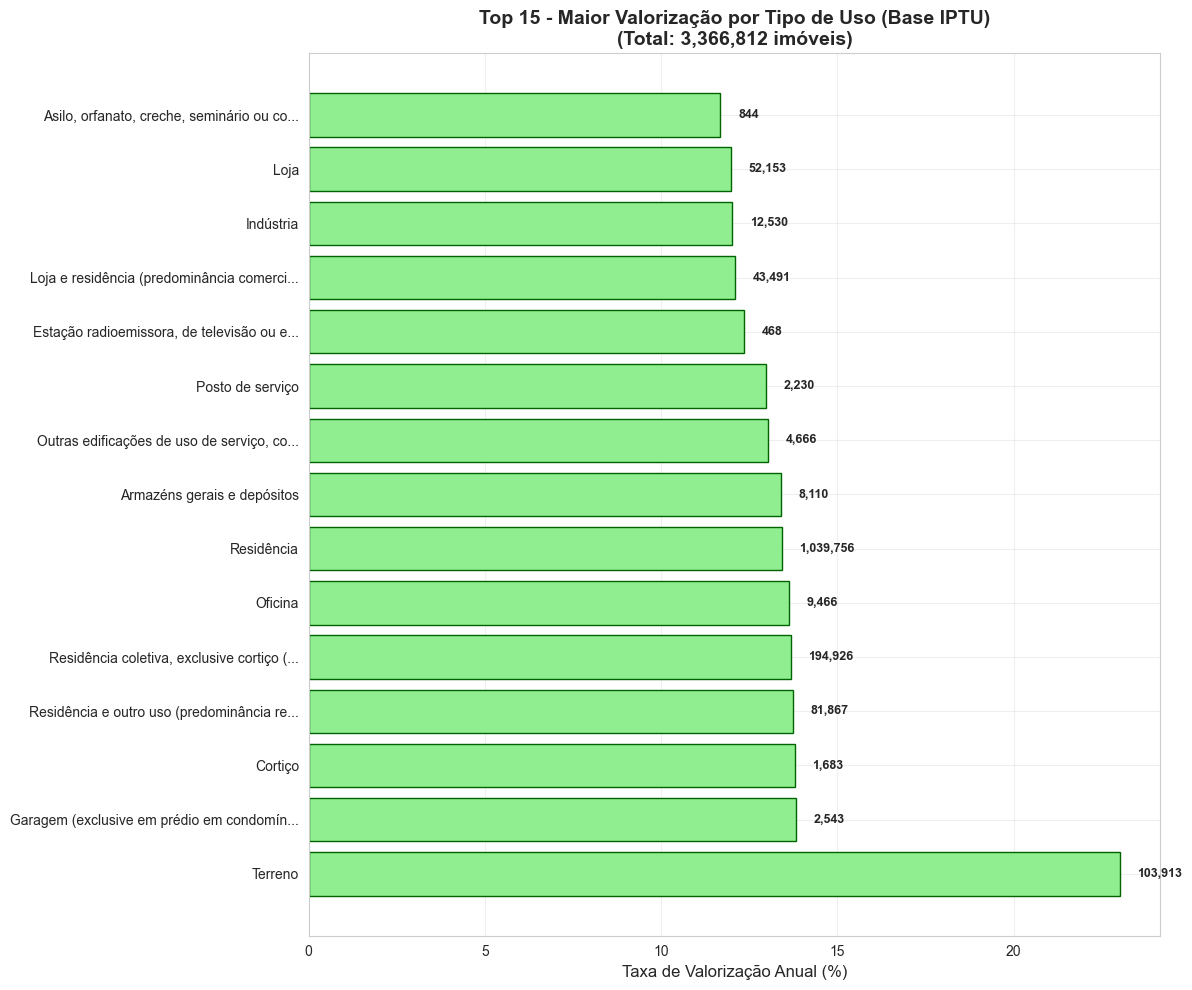


📈 Exibindo gráfico 2: Top 15 Menores Valorizações...
💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_top15_menores_individual.png


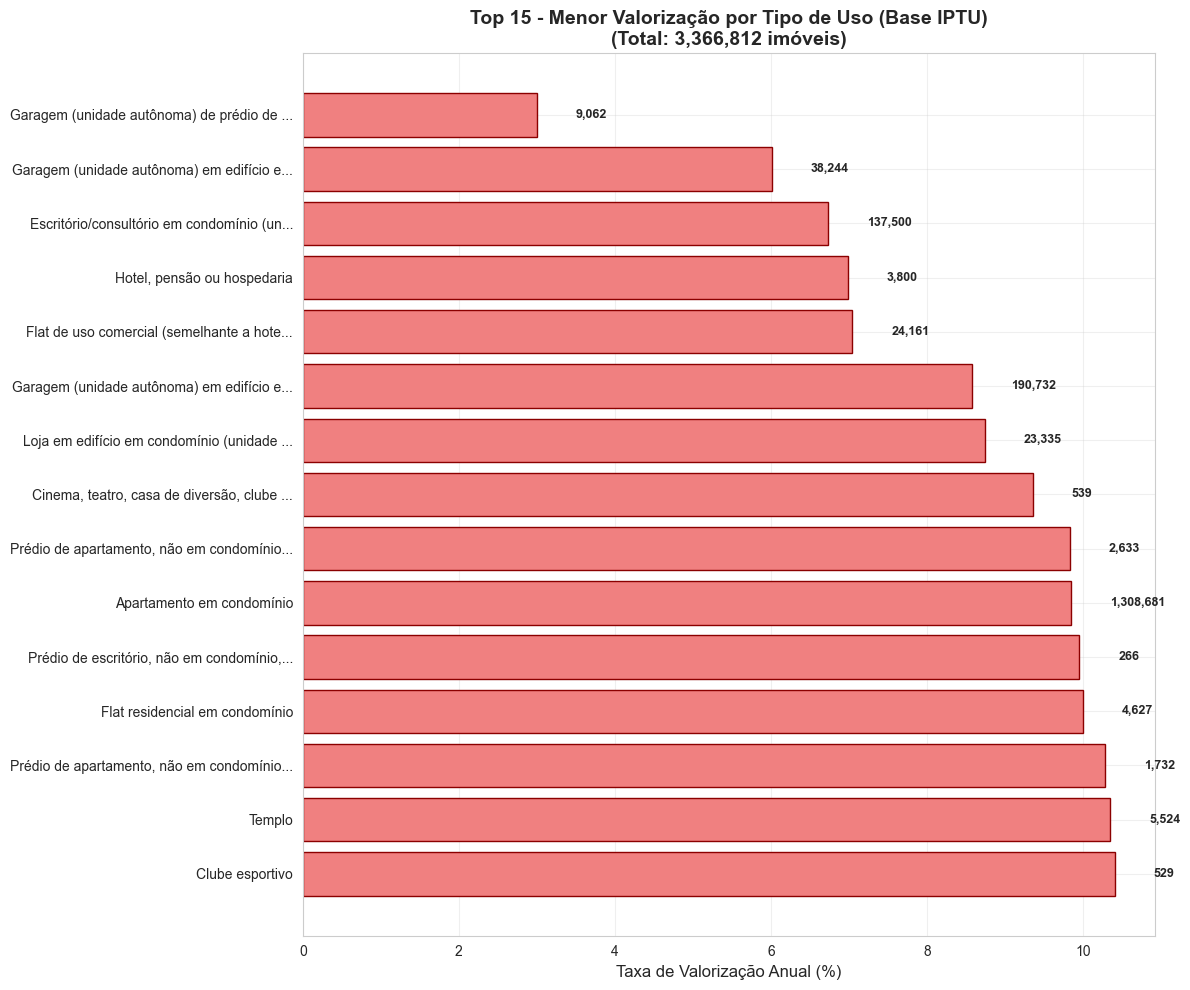


📈 Exibindo gráfico 3: Box Plot - Distribuição das Taxas (Top 10 por Volume)...
💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_boxplot_individual.png


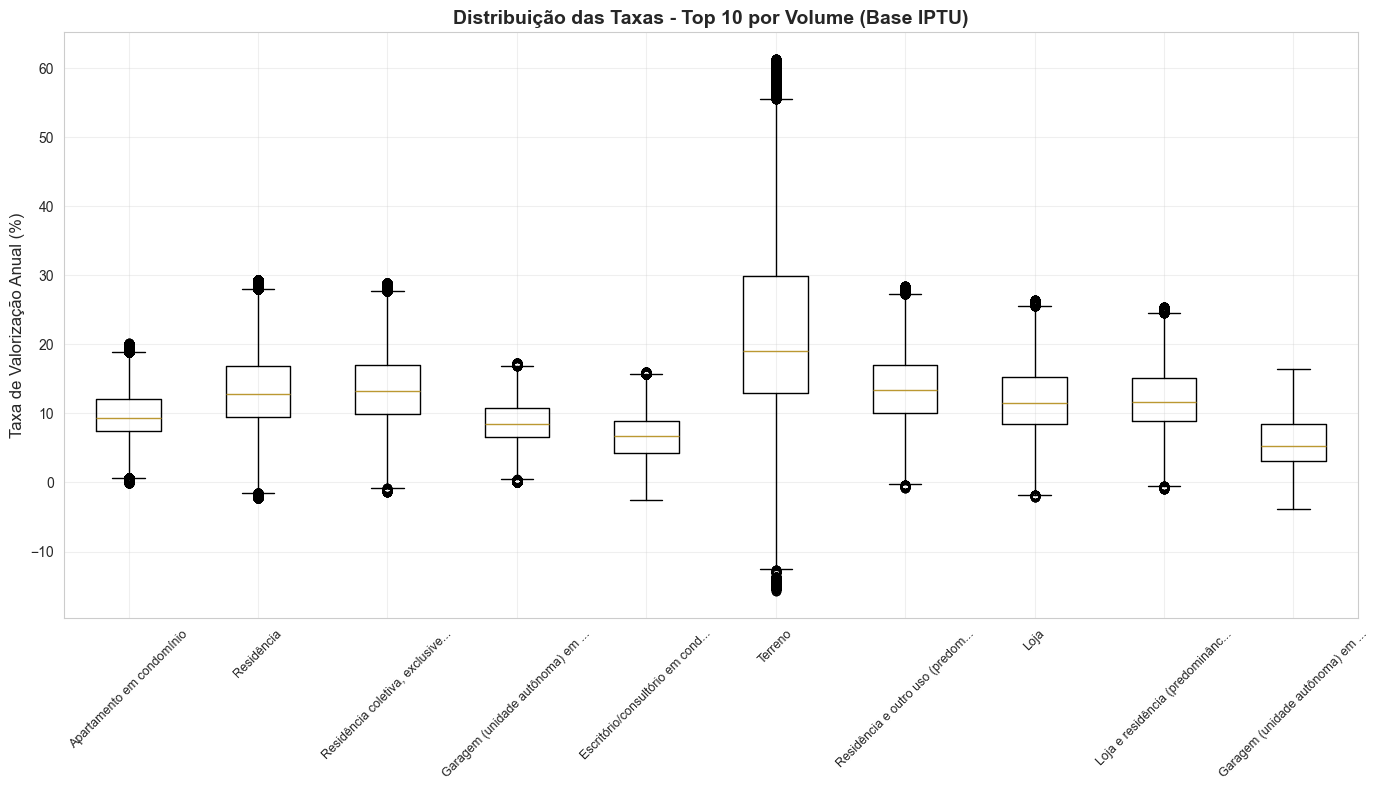


📈 Exibindo gráfico 4: Volume vs Taxa de Valorização...
💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_scatter_individual.png


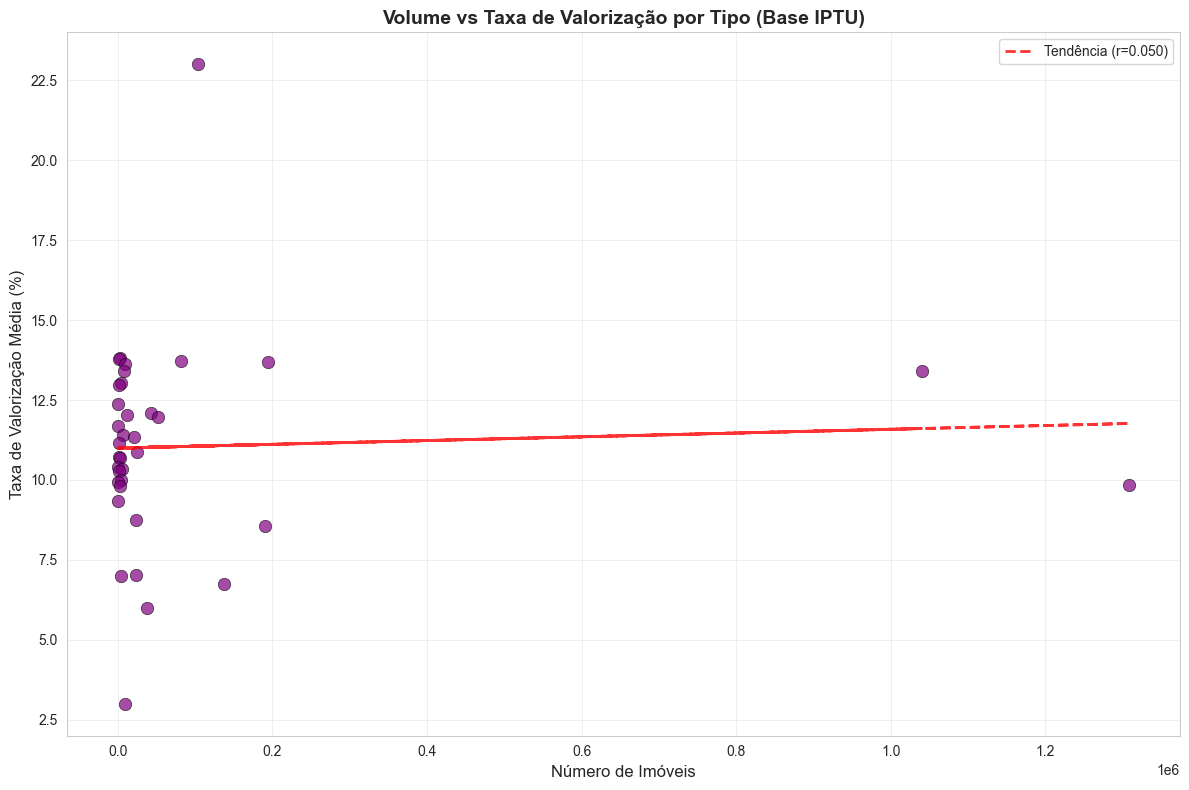


📅 Exibindo gráfico 5: Evolução Temporal - Top 10 Maiores Valorizações...
💾 Gráfico salvo em: dados_processados/evolucao_temporal_valorizacao_iptu_top10_maiores_individual.png


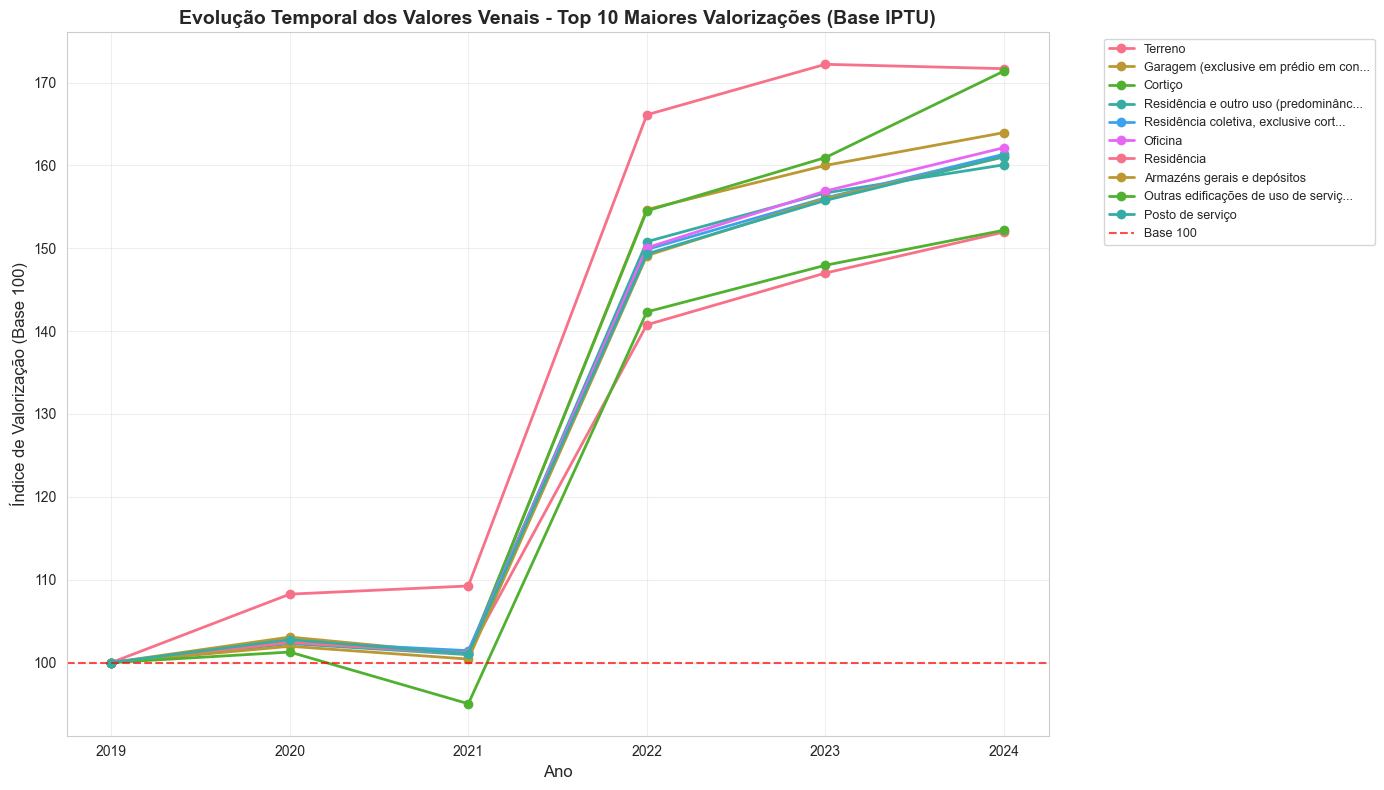


📅 Exibindo gráfico 6: Evolução Temporal - Top 10 Menores Valorizações...
💾 Gráfico salvo em: dados_processados/evolucao_temporal_valorizacao_iptu_top10_menores_individual.png


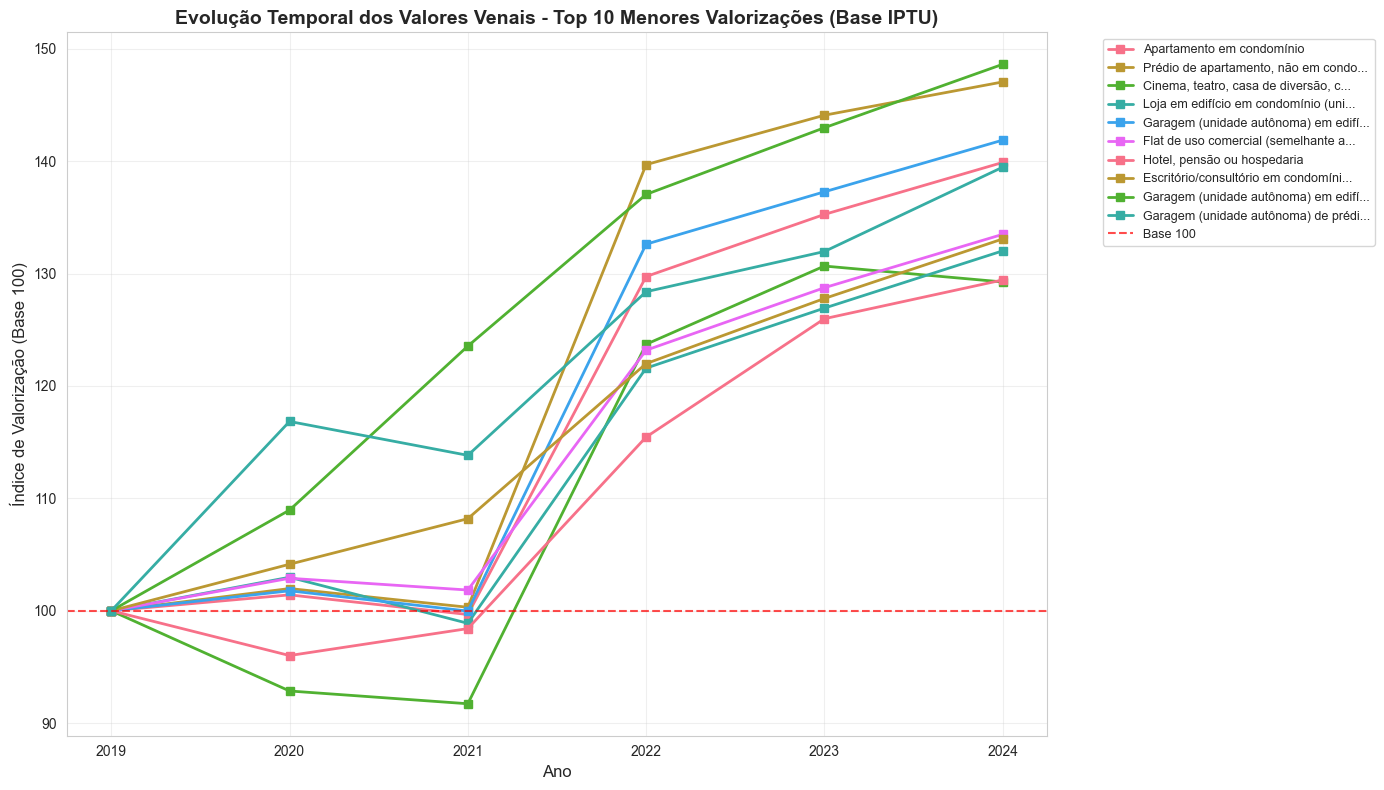


                    ✅ VISUALIZAÇÕES INDIVIDUAIS CONCLUÍDAS!                     

💾 ARQUIVOS GERADOS (INDIVIDUAIS):
   • dados_processados/valorizacao_por_tipo_iptu_top15_maiores_individual.png
   • dados_processados/valorizacao_por_tipo_iptu_top15_menores_individual.png
   • dados_processados/valorizacao_por_tipo_iptu_boxplot_individual.png
   • dados_processados/valorizacao_por_tipo_iptu_scatter_individual.png
   • dados_processados/evolucao_temporal_valorizacao_iptu_top10_maiores_individual.png
   • dados_processados/evolucao_temporal_valorizacao_iptu_top10_menores_individual.png


In [ ]:
# ============================================================================
# PASSO 7B: VISUALIZAÇÕES INDIVIDUAIS (exibindo cada gráfico separadamente)
# ============================================================================

if 'stats_por_tipo_iptu' in locals() and len(stats_por_tipo_iptu) > 0:
    print('\n📊 PASSO 7B: VISUALIZAÇÕES INDIVIDUAIS\n')
    
    # ============================================================================
    # GRÁFICO 1: Top 15 Maiores Valorizações
    # ============================================================================
    
    print('\n📈 Exibindo gráfico 1: Top 15 Maiores Valorizações...')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    top_15_maior = stats_por_tipo_iptu.head(15)
    bars = ax.barh(range(len(top_15_maior)), top_15_maior['Taxa_Media'], 
                   color='lightgreen', edgecolor='darkgreen', linewidth=1)
    ax.set_yticks(range(len(top_15_maior)))
    ax.set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                       for name in top_15_maior.index], fontsize=10)
    ax.set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
    ax.set_title(f'Top 15 - Maior Valorização por Tipo de Uso (Base IPTU)\n(Total: {len(df_taxas_iptu_limpas):,} imóveis)', 
               fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Adicionar número de imóveis nas barras
    for i, (bar, count) in enumerate(zip(bars, top_15_maior['Count'])):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
              f'{int(count):,}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dados_processados/valorizacao_por_tipo_iptu_top15_maiores_individual.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_top15_maiores_individual.png')
    plt.show()
    
    # ============================================================================
    # GRÁFICO 2: Top 15 Menores Valorizações
    # ============================================================================
    
    print('\n📈 Exibindo gráfico 2: Top 15 Menores Valorizações...')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    top_15_menor = stats_por_tipo_iptu.tail(15)
    bars = ax.barh(range(len(top_15_menor)), top_15_menor['Taxa_Media'], 
                   color='lightcoral', edgecolor='darkred', linewidth=1)
    ax.set_yticks(range(len(top_15_menor)))
    ax.set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                       for name in top_15_menor.index], fontsize=10)
    ax.set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
    ax.set_title(f'Top 15 - Menor Valorização por Tipo de Uso (Base IPTU)\n(Total: {len(df_taxas_iptu_limpas):,} imóveis)', 
               fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Adicionar número de imóveis nas barras
    for i, (bar, count) in enumerate(zip(bars, top_15_menor['Count'])):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
              f'{int(count):,}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dados_processados/valorizacao_por_tipo_iptu_top15_menores_individual.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_top15_menores_individual.png')
    plt.show()
    
    # ============================================================================
    # GRÁFICO 3: Box Plot das Taxas por Tipo (Top 10 por Volume)
    # ============================================================================
    
    print('\n📈 Exibindo gráfico 3: Box Plot - Distribuição das Taxas (Top 10 por Volume)...')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    top_10_volume = stats_por_tipo_iptu.nlargest(10, 'Count')
    tipos_top_volume = top_10_volume.index.tolist()
    dados_boxplot = [df_taxas_iptu_limpas[df_taxas_iptu_limpas['tipo_uso'] == tipo]['taxa_valorizacao_anual'].values 
                     for tipo in tipos_top_volume]
    
    ax.boxplot(dados_boxplot, labels=[name[:30] + '...' if len(name) > 30 else name 
                                      for name in tipos_top_volume])
    ax.set_ylabel('Taxa de Valorização Anual (%)', fontsize=12)
    ax.set_title('Distribuição das Taxas - Top 10 por Volume (Base IPTU)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dados_processados/valorizacao_por_tipo_iptu_boxplot_individual.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_boxplot_individual.png')
    plt.show()
    
    # ============================================================================
    # GRÁFICO 4: Scatter Plot - Volume vs Taxa de Valorização
    # ============================================================================
    
    print('\n📈 Exibindo gráfico 4: Volume vs Taxa de Valorização...')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.scatter(stats_por_tipo_iptu['Count'], stats_por_tipo_iptu['Taxa_Media'], 
              s=80, alpha=0.7, color='purple', edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Número de Imóveis', fontsize=12)
    ax.set_ylabel('Taxa de Valorização Média (%)', fontsize=12)
    ax.set_title('Volume vs Taxa de Valorização por Tipo (Base IPTU)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Adicionar linha de tendência
    z = np.polyfit(stats_por_tipo_iptu['Count'], stats_por_tipo_iptu['Taxa_Media'], 1)
    p = np.poly1d(z)
    correlacao = stats_por_tipo_iptu['Count'].corr(stats_por_tipo_iptu['Taxa_Media'])
    ax.plot(stats_por_tipo_iptu['Count'], p(stats_por_tipo_iptu['Count']), 
           "r--", alpha=0.8, linewidth=2, 
           label=f'Tendência (r={correlacao:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('dados_processados/valorizacao_por_tipo_iptu_scatter_individual.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/valorizacao_por_tipo_iptu_scatter_individual.png')
    plt.show()
    
    # ============================================================================
    # GRÁFICO 5: Evolução Temporal - Top 10 Maiores Valorizações
    # ============================================================================
    
    print('\n📅 Exibindo gráfico 5: Evolução Temporal - Top 10 Maiores Valorizações...')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    top_10_tipos_valorizacao = stats_por_tipo_iptu.head(10).index.tolist()
    
    # Evolução temporal dos valores venais para top 10 tipos
    for i, tipo in enumerate(top_10_tipos_valorizacao):
        # Filtrar dados do tipo específico
        dados_tipo = df_valorizacao_iptu_filtrado[
            df_valorizacao_iptu_filtrado[tipo_uso_col] == tipo
        ]
        
        # Pegar imóveis deste tipo que têm taxa calculada
        cadastros_tipo = df_taxas_iptu_limpas[
            df_taxas_iptu_limpas['tipo_uso'] == tipo
        ]['cadastro'].unique()
        
        dados_tipo_filtrado = dados_tipo[
            dados_tipo['NUMERO DO CONTRIBUINTE'].isin(cadastros_tipo)
        ]
        
        # Calcular evolução temporal dos valores venais médios
        if len(dados_tipo_filtrado) > 0:
            evolucao_tipo = dados_tipo_filtrado.groupby('ANO')['VALOR VENAL'].mean()
            
            # Normalizar para base 100 (primeiro ano = 100)
            if len(evolucao_tipo) > 0:
                valor_base = evolucao_tipo.iloc[0]
                if valor_base > 0:
                    evolucao_normalizada = (evolucao_tipo / valor_base) * 100
                    
                    ax.plot(evolucao_normalizada.index, evolucao_normalizada.values, 
                            marker='o', linewidth=2, markersize=6,
                            label=tipo[:35] + '...' if len(tipo) > 35 else tipo)
    
    ax.set_xlabel('Ano', fontsize=12)
    ax.set_ylabel('Índice de Valorização (Base 100)', fontsize=12)
    ax.set_title('Evolução Temporal dos Valores Venais - Top 10 Maiores Valorizações (Base IPTU)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Base 100')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('dados_processados/evolucao_temporal_valorizacao_iptu_top10_maiores_individual.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/evolucao_temporal_valorizacao_iptu_top10_maiores_individual.png')
    plt.show()
    
    # ============================================================================
    # GRÁFICO 6: Evolução Temporal - Top 10 Menores Valorizações
    # ============================================================================
    
    print('\n📅 Exibindo gráfico 6: Evolução Temporal - Top 10 Menores Valorizações...')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    bottom_10_tipos_valorizacao = stats_por_tipo_iptu.tail(10).index.tolist()
    
    # Evolução temporal dos valores venais para bottom 10 tipos
    for i, tipo in enumerate(bottom_10_tipos_valorizacao):
        dados_tipo = df_valorizacao_iptu_filtrado[
            df_valorizacao_iptu_filtrado[tipo_uso_col] == tipo
        ]
        
        cadastros_tipo = df_taxas_iptu_limpas[
            df_taxas_iptu_limpas['tipo_uso'] == tipo
        ]['cadastro'].unique()
        
        dados_tipo_filtrado = dados_tipo[
            dados_tipo['NUMERO DO CONTRIBUINTE'].isin(cadastros_tipo)
        ]
        
        if len(dados_tipo_filtrado) > 0:
            evolucao_tipo = dados_tipo_filtrado.groupby('ANO')['VALOR VENAL'].mean()
            
            if len(evolucao_tipo) > 0:
                valor_base = evolucao_tipo.iloc[0]
                if valor_base > 0:
                    evolucao_normalizada = (evolucao_tipo / valor_base) * 100
                    
                    ax.plot(evolucao_normalizada.index, evolucao_normalizada.values, 
                            marker='s', linewidth=2, markersize=6,
                            label=tipo[:35] + '...' if len(tipo) > 35 else tipo)
    
    ax.set_xlabel('Ano', fontsize=12)
    ax.set_ylabel('Índice de Valorização (Base 100)', fontsize=12)
    ax.set_title('Evolução Temporal dos Valores Venais - Top 10 Menores Valorizações (Base IPTU)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Base 100')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('dados_processados/evolucao_temporal_valorizacao_iptu_top10_menores_individual.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/evolucao_temporal_valorizacao_iptu_top10_menores_individual.png')
    plt.show()
    
    # ============================================================================
    # RESUMO DAS VISUALIZAÇÕES INDIVIDUAIS
    # ============================================================================
    
    print('\n' + '='*80)
    print('✅ VISUALIZAÇÕES INDIVIDUAIS CONCLUÍDAS!'.center(80))
    print('='*80)
    
    print(f'\n💾 ARQUIVOS GERADOS (INDIVIDUAIS):')
    print(f'   • dados_processados/valorizacao_por_tipo_iptu_top15_maiores_individual.png')
    print(f'   • dados_processados/valorizacao_por_tipo_iptu_top15_menores_individual.png')
    print(f'   • dados_processados/valorizacao_por_tipo_iptu_boxplot_individual.png')
    print(f'   • dados_processados/valorizacao_por_tipo_iptu_scatter_individual.png')
    print(f'   • dados_processados/evolucao_temporal_valorizacao_iptu_top10_maiores_individual.png')
    print(f'   • dados_processados/evolucao_temporal_valorizacao_iptu_top10_menores_individual.png')
    print('='*80)
else:
    print('\n⚠️ Visualizações individuais não disponíveis (análise por tipo de uso não foi realizada)')



## 5. Ajuste da Taxa de Valorização com Diferença Real vs Venal

**Objetivo:** Aproximar a taxa de valorização calculada baseada no valor venal (estimado pela Prefeitura) da realidade de mercado, utilizando a diferença observada entre valor real (transações ITBI) e valor venal (IPTU).

**Metodologia:**
1. Calcular a diferença percentual média entre VALOR REAL e VALOR VENAL por tipo de uso usando dados das transações (`df_merged_clean`)
2. Aplicar essa diferença percentual como fator de correção às taxas de valorização calculadas sobre o valor venal
3. Apresentar resultados comparativos: antes (taxa venal) e depois (taxa ajustada)

**Premissa:** O valor venal é uma estimativa. A diferença percentual entre valor real e venal observada nas transações reflete sistematicamente o desvio do valor venal em relação ao mercado real. Ao aplicar essa diferença à taxa calculada sobre o valor venal, aproximamos a taxa de valorização da realidade de mercado.

**Fórmula de Ajuste:**
- Diferença percentual por tipo: `diff_pct = ((VALOR REAL - VALOR VENAL) / VALOR VENAL) * 100`
- Taxa ajustada: `taxa_ajustada = taxa_venal * (1 + diff_pct/100)`

**Resultados apresentados:**
- Taxa base (valor venal) por tipo de uso
- Diferença percentual média (real vs venal) por tipo de uso
- Taxa ajustada (corrigida) por tipo de uso
- Comparação visual antes/depois


         4.5. AJUSTE DA TAXA DE VALORIZAÇÃO COM DIFERENÇA REAL VS VENAL         

📊 PASSO 1: CÁLCULO DA DIFERENÇA PERCENTUAL REAL VS VENAL POR TIPO DE USO

✅ Dados de transações disponíveis: 568,412 registros
   Tipos de uso únicos: 37
   Registros válidos após limpeza: 568,412

📈 ESTATÍSTICAS DA DIFERENÇA PERCENTUAL POR TIPO DE USO:
   Tipos analisados: 37
   Total de transações: 568,412
   Diferença média geral: 92.46%
   Diferença mediana geral: 62.91%

🔝 TOP 15 TIPOS COM MAIOR DIFERENÇA (VALOR REAL > VENAL):


,Count,Diff_Media,Diff_Mediana,Valor_Real_Medio,Valor_Venal_Medio
TIPO DE USO DO IMOVEL,,,,,
Terreno,9468,208.281,68.224,1.029587e+06,486464.369
"Prédio de escritório, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios) com ou sem loja (predominância comercial)",33,123.006,51.782,1.577918e+07,8669802.132
Residência,105770,116.098,77.253,7.822390e+05,417436.385
"Hospital, ambulatório, casa de saúde e assemelhados",140,109.818,62.449,1.076495e+07,4439035.805
Garagem (exclusive em prédio em condomínio),423,109.806,61.557,5.089794e+06,2415438.080
Loja,5968,107.494,55.502,3.118958e+06,1610033.926
Loja em edifício em condomínio (unidade autônoma),2856,106.568,51.131,9.987395e+05,539631.238
"Prédio de escritório ou consultório, não em condomínio, com ou sem lojas",3765,101.840,56.269,4.292662e+06,2328432.182
"Prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)",245,101.350,50.903,2.463557e+06,1341754.366



🔻 TOP 15 TIPOS COM MENOR DIFERENÇA (ou VALOR REAL < VENAL):


,Count,Diff_Media,Diff_Mediana,Valor_Real_Medio,Valor_Venal_Medio
TIPO DE USO DO IMOVEL,,,,,
Indústria,1482,79.923,47.923,4.409167e+06,2687550.369
"Residência coletiva, exclusive cortiço (mais de uma residência no lote)",10756,78.286,48.798,6.633125e+05,391202.816
"Cinema, teatro, casa de diversão, clube ou congênere",50,78.232,52.320,1.178486e+07,6635747.009
"Hotel, pensão ou hospedaria",1378,72.330,60.881,9.589535e+05,517668.251
Clube esportivo,48,70.977,47.164,8.103714e+06,5292345.698
Templo,148,68.629,46.129,2.993242e+06,1694623.112
"Prédio de apartamento, não em condomínio, de uso exclusivamente residencial",230,66.604,49.348,1.494404e+06,837286.443
Cortiço,86,61.686,45.134,8.104737e+05,511309.363
Garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial,41620,57.752,43.376,9.680557e+04,65115.672



💾 Gráfico salvo em: dados_processados/diferenca_real_venal_por_tipo.png


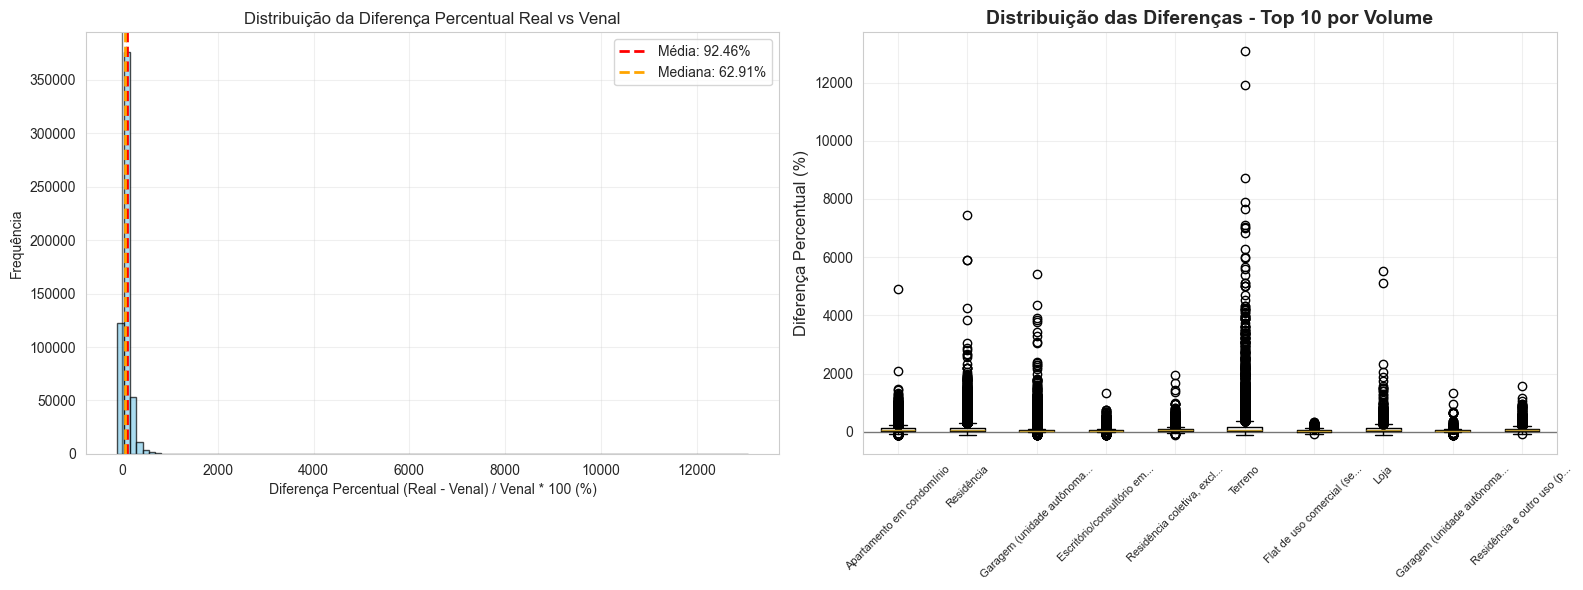

In [ ]:
# ============================================================================
# 4.5. AJUSTE DA TAXA DE VALORIZAÇÃO COM DIFERENÇA REAL VS VENAL
# ============================================================================

print('='*80)
print('4.5. AJUSTE DA TAXA DE VALORIZAÇÃO COM DIFERENÇA REAL VS VENAL'.center(80))
print('='*80)

import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PASSO 1: CALCULAR DIFERENÇA PERCENTUAL POR TIPO DE USO (df_merged_clean)
# ============================================================================

print('\n📊 PASSO 1: CÁLCULO DA DIFERENÇA PERCENTUAL REAL VS VENAL POR TIPO DE USO\n')

# Verificar se df_merged_clean existe
if 'df_merged_clean' not in globals():
    print('❌ df_merged_clean não encontrado!')
    print('   Execute primeiro a seção 3 (preparação dos dados)')
    raise ValueError('df_merged_clean não encontrado')

# Verificar colunas necessárias
required_cols_merge = ['VALOR REAL', 'VALOR VENAL', 'TIPO DE USO DO IMOVEL']
missing_cols = [col for col in required_cols_merge if col not in df_merged_clean.columns]

if missing_cols:
    print(f'❌ Colunas faltando em df_merged_clean: {missing_cols}')
    print(f'Colunas disponíveis: {list(df_merged_clean.columns)}')
    raise ValueError(f'Colunas necessárias não encontradas: {missing_cols}')

print(f'✅ Dados de transações disponíveis: {len(df_merged_clean):,} registros')
print(f'   Tipos de uso únicos: {df_merged_clean["TIPO DE USO DO IMOVEL"].nunique()}')

# Limpar dados: apenas registros com valores válidos
df_diferenca = df_merged_clean[
    df_merged_clean['VALOR REAL'].notna() & 
    df_merged_clean['VALOR VENAL'].notna() &
    (df_merged_clean['VALOR REAL'] > 0) &
    (df_merged_clean['VALOR VENAL'] > 0)
].copy()

print(f'   Registros válidos após limpeza: {len(df_diferenca):,}')

# Calcular diferença percentual: ((VALOR REAL - VALOR VENAL) / VALOR VENAL) * 100
df_diferenca['DIFERENCA_PERCENTUAL'] = ((df_diferenca['VALOR REAL'] - df_diferenca['VALOR VENAL']) / 
                                        df_diferenca['VALOR VENAL']) * 100

# Calcular estatísticas agregadas por tipo de uso
diff_por_tipo = df_diferenca.groupby('TIPO DE USO DO IMOVEL').agg({
    'DIFERENCA_PERCENTUAL': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'VALOR REAL': 'mean',
    'VALOR VENAL': 'mean'
}).round(3)

# Flatten das colunas multi-index
diff_por_tipo.columns = ['Count', 'Diff_Media', 'Diff_Mediana', 'Diff_Std', 
                         'Diff_Min', 'Diff_Max', 'Valor_Real_Medio', 'Valor_Venal_Medio']

# Ordenar por diferença média
diff_por_tipo = diff_por_tipo.sort_values('Diff_Media', ascending=False)

print(f'\n📈 ESTATÍSTICAS DA DIFERENÇA PERCENTUAL POR TIPO DE USO:')
print(f'   Tipos analisados: {len(diff_por_tipo)}')
print(f'   Total de transações: {diff_por_tipo["Count"].sum():,}')
print(f'   Diferença média geral: {df_diferenca["DIFERENCA_PERCENTUAL"].mean():.2f}%')
print(f'   Diferença mediana geral: {df_diferenca["DIFERENCA_PERCENTUAL"].median():.2f}%')

# Mostrar top 15 tipos com maior diferença (valor real > venal)
print(f'\n🔝 TOP 15 TIPOS COM MAIOR DIFERENÇA (VALOR REAL > VENAL):')
display(diff_por_tipo.head(15)[['Count', 'Diff_Media', 'Diff_Mediana', 'Valor_Real_Medio', 'Valor_Venal_Medio']])

# Mostrar top 15 tipos com menor diferença (ou negativo, se valor real < venal)
print(f'\n🔻 TOP 15 TIPOS COM MENOR DIFERENÇA (ou VALOR REAL < VENAL):')
display(diff_por_tipo.tail(15)[['Count', 'Diff_Media', 'Diff_Mediana', 'Valor_Real_Medio', 'Valor_Venal_Medio']])

# Visualização da distribuição das diferenças
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma das diferenças gerais
axes[0].hist(df_diferenca['DIFERENCA_PERCENTUAL'], bins=100, 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_diferenca['DIFERENCA_PERCENTUAL'].mean(), 
                color='red', linestyle='--', linewidth=2, 
                label=f'Média: {df_diferenca["DIFERENCA_PERCENTUAL"].mean():.2f}%')
axes[0].axvline(df_diferenca['DIFERENCA_PERCENTUAL'].median(), 
                color='orange', linestyle='--', linewidth=2, 
                label=f'Mediana: {df_diferenca["DIFERENCA_PERCENTUAL"].median():.2f}%')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Diferença Percentual (Real - Venal) / Venal * 100 (%)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição da Diferença Percentual Real vs Venal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot por tipo (top 10 por volume)
top_10_volume_diff = diff_por_tipo.nlargest(10, 'Count')
tipos_top_volume_diff = top_10_volume_diff.index.tolist()
dados_boxplot_diff = [df_diferenca[df_diferenca['TIPO DE USO DO IMOVEL'] == tipo]['DIFERENCA_PERCENTUAL'].values 
                     for tipo in tipos_top_volume_diff]

axes[1].boxplot(dados_boxplot_diff, labels=[name[:25] + '...' if len(name) > 25 else name 
                                            for name in tipos_top_volume_diff])
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_ylabel('Diferença Percentual (%)', fontsize=12)
axes[1].set_title('Distribuição das Diferenças - Top 10 por Volume', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dados_processados/diferenca_real_venal_por_tipo.png', dpi=300, bbox_inches='tight')
print('\n💾 Gráfico salvo em: dados_processados/diferenca_real_venal_por_tipo.png')
plt.show()


In [ ]:
# ============================================================================
# PASSO 2: COMBINAR TAXAS DE VALORIZAÇÃO COM DIFERENÇAS POR TIPO DE USO
# ============================================================================

print('\n📊 PASSO 2: COMBINAÇÃO DE TAXAS DE VALORIZAÇÃO COM DIFERENÇAS\n')

# Verificar se temos as taxas calculadas na seção 4.4
if 'stats_por_tipo_iptu' not in locals() or len(stats_por_tipo_iptu) == 0:
    print('⚠️ Taxas de valorização por tipo de uso não encontradas!')
    print('   Execute primeiro a seção 4.4 para calcular as taxas baseadas no valor venal')
    raise ValueError('stats_por_tipo_iptu não encontrado')

print(f'✅ Taxas de valorização disponíveis para {len(stats_por_tipo_iptu)} tipos de uso')

# Criar DataFrame combinado
# Renomear coluna de tipo de uso em diff_por_tipo para facilitar merge
diff_por_tipo_reset = diff_por_tipo.reset_index()
diff_por_tipo_reset.rename(columns={'TIPO DE USO DO IMOVEL': 'tipo_uso'}, inplace=True)

# Renomear coluna em stats_por_tipo_iptu se necessário
stats_por_tipo_iptu_reset = stats_por_tipo_iptu.reset_index()

# Realizar merge das taxas com as diferenças
df_comparacao = pd.merge(
    stats_por_tipo_iptu_reset,
    diff_por_tipo_reset,
    on='tipo_uso',
    how='inner',
    suffixes=('_taxa', '_diff')
)

print(f'\n✅ Merge realizado: {len(df_comparacao)} tipos de uso com dados completos')
print(f'   Tipos apenas com taxa (sem diferença): {len(stats_por_tipo_iptu) - len(df_comparacao)}')
print(f'   Tipos apenas com diferença (sem taxa): {len(diff_por_tipo) - len(df_comparacao)}')

# ============================================================================
# PASSO 3: APLICAR AJUSTE ÀS TAXAS DE VALORIZAÇÃO
# ============================================================================

print('\n📊 PASSO 3: APLICAÇÃO DO AJUSTE ÀS TAXAS DE VALORIZAÇÃO\n')

# Aplicar ajuste: taxa_ajustada = taxa_venal * (1 + diff_pct/100)
# A diferença percentual já está em %, então dividimos por 100
df_comparacao['Taxa_Ajustada'] = df_comparacao['Taxa_Media'] * (1 + df_comparacao['Diff_Media'] / 100)

# Também calcular ajuste para a mediana
df_comparacao['Taxa_Mediana_Ajustada'] = df_comparacao['Taxa_Mediana'] * (1 + df_comparacao['Diff_Mediana'] / 100)

# Calcular mudança absoluta e percentual
df_comparacao['Mudanca_Absoluta'] = df_comparacao['Taxa_Ajustada'] - df_comparacao['Taxa_Media']
df_comparacao['Mudanca_Percentual'] = (df_comparacao['Mudanca_Absoluta'] / df_comparacao['Taxa_Media']) * 100

# Ordenar por taxa ajustada (maior para menor)
df_comparacao = df_comparacao.sort_values('Taxa_Ajustada', ascending=False)

print(f'\n📈 ESTATÍSTICAS DO AJUSTE:')
print(f'   Tipos ajustados: {len(df_comparacao)}')
print(f'   Taxa média antes (venal): {df_comparacao["Taxa_Media"].mean():.2f}% ao ano')
print(f'   Taxa média depois (ajustada): {df_comparacao["Taxa_Ajustada"].mean():.2f}% ao ano')
print(f'   Mudança média absoluta: {df_comparacao["Mudanca_Absoluta"].mean():.2f} pontos percentuais')
print(f'   Mudança média percentual: {df_comparacao["Mudanca_Percentual"].mean():.2f}%')

# Mostrar resumo antes/depois para top 15
print(f'\n🔝 TOP 15 - COMPARAÇÃO ANTES/DEPOIS DO AJUSTE:')
colunas_comparacao = ['tipo_uso', 'Taxa_Media', 'Diff_Media', 'Taxa_Ajustada', 'Mudanca_Absoluta']
display(df_comparacao.head(15)[colunas_comparacao].round(2))

# Mostrar bottom 15
print(f'\n🔻 BOTTOM 15 - COMPARAÇÃO ANTES/DEPOIS DO AJUSTE:')
display(df_comparacao.tail(15)[colunas_comparacao].round(2))



📊 PASSO 2: COMBINAÇÃO DE TAXAS DE VALORIZAÇÃO COM DIFERENÇAS

✅ Taxas de valorização disponíveis para 36 tipos de uso

✅ Merge realizado: 36 tipos de uso com dados completos
   Tipos apenas com taxa (sem diferença): 0
   Tipos apenas com diferença (sem taxa): 1

📊 PASSO 3: APLICAÇÃO DO AJUSTE ÀS TAXAS DE VALORIZAÇÃO


📈 ESTATÍSTICAS DO AJUSTE:
   Tipos ajustados: 36
   Taxa média antes (venal): 11.05% ao ano
   Taxa média depois (ajustada): 21.35% ao ano
   Mudança média absoluta: 10.30 pontos percentuais
   Mudança média percentual: 86.64%

🔝 TOP 15 - COMPARAÇÃO ANTES/DEPOIS DO AJUSTE:


,tipo_uso,Taxa_Media,Diff_Media,Taxa_Ajustada,Mudanca_Absoluta
0,Terreno,23.00,208.28,70.91,47.91
1,Garagem (exclusive em prédio em condomínio),13.83,109.81,29.01,15.18
6,Residência,13.42,116.10,29.01,15.58
3,Residência e outro uso (predominância residenc...,13.73,90.16,26.10,12.38
5,Oficina,13.62,89.35,25.80,12.17
8,"Outras edificações de uso de serviço, com util...",13.03,97.55,25.74,12.71
9,Posto de serviço,12.96,93.22,25.05,12.09
13,Loja,11.98,107.49,24.87,12.88
10,"Estação radioemissora, de televisão ou empresa...",12.36,100.39,24.77,12.41
7,Armazéns gerais e depósitos,13.40,83.37,24.56,11.17



🔻 BOTTOM 15 - COMPARAÇÃO ANTES/DEPOIS DO AJUSTE:


,tipo_uso,Taxa_Media,Diff_Media,Taxa_Ajustada,Mudanca_Absoluta
27,"Prédio de apartamento, não em condomínio, de u...",9.83,101.35,19.78,9.96
20,"Outras edificações de uso coletivo, com utiliz...",10.70,84.18,19.70,9.01
26,Apartamento em condomínio,9.85,92.14,18.92,9.07
29,Loja em edifício em condomínio (unidade autônoma),8.74,106.57,18.05,9.31
21,Clube esportivo,10.40,70.98,17.78,7.38
22,Templo,10.35,68.63,17.45,7.10
23,"Prédio de apartamento, não em condomínio, de u...",10.28,66.60,17.13,6.85
28,"Cinema, teatro, casa de diversão, clube ou con...",9.35,78.23,16.67,7.32
30,Garagem (unidade autônoma) em edifício em cond...,8.57,57.75,13.53,4.95
24,Flat residencial em condomínio,9.99,33.08,13.30,3.31



📊 PASSO 4: VISUALIZAÇÕES COMPARATIVAS ANTES/DEPOIS

💾 Gráfico comparativo salvo em: dados_processados/comparacao_taxas_antes_depois.png


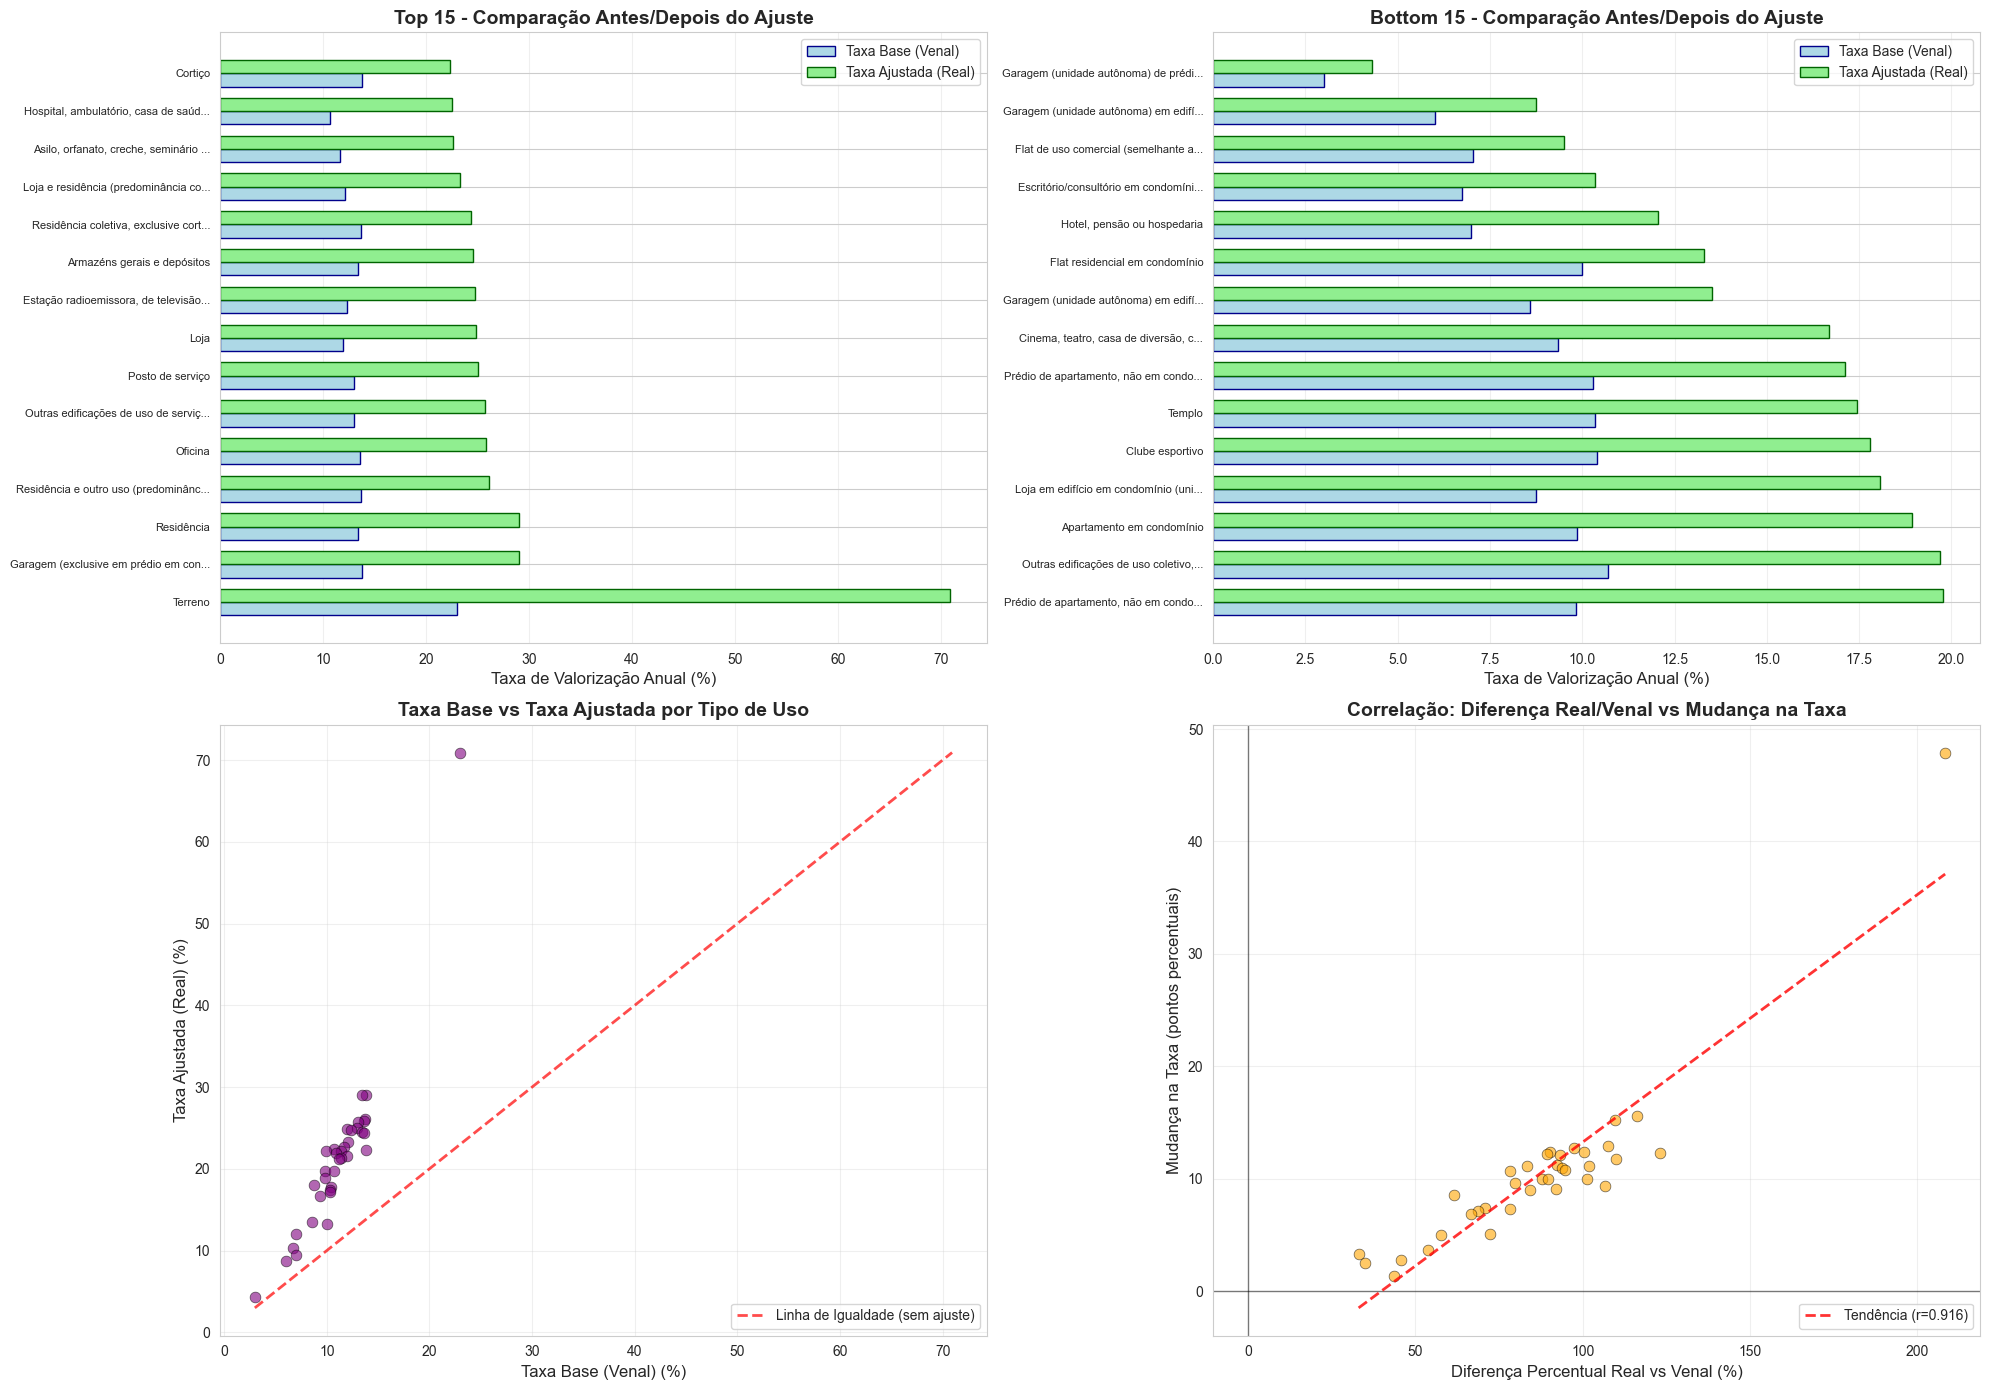


📊 TABELA RESUMO CONSOLIDADA - TOP 20:

Colunas disponíveis: ['tipo_uso', 'Count_taxa', 'Taxa_Media', 'Taxa_Mediana', 'Taxa_Std', 'Taxa_Min', 'Taxa_Max', 'R2_Medio', 'Obs_Media', 'Anos_Cobertos']...


,Tipo de Uso,N Imóveis,Taxa Base (%),Diferença Real/Venal (%),Taxa Ajustada (%),Mudança Absoluta (pp),Mudança Relativa (%)
0,Terreno,103913,23.00,208.28,70.91,47.91,208.28
1,Garagem (exclusive em prédio em condomínio),2543,13.83,109.81,29.01,15.18,109.81
6,Residência,1039756,13.42,116.10,29.01,15.58,116.10
3,Residência e outro uso (predominância residenc...,81867,13.73,90.16,26.10,12.38,90.16
5,Oficina,9466,13.62,89.35,25.80,12.17,89.35
8,"Outras edificações de uso de serviço, com util...",4666,13.03,97.55,25.74,12.71,97.55
9,Posto de serviço,2230,12.96,93.22,25.05,12.09,93.22
13,Loja,52153,11.98,107.49,24.87,12.88,107.49
10,"Estação radioemissora, de televisão ou empresa...",468,12.36,100.39,24.77,12.41,100.39
7,Armazéns gerais e depósitos,8110,13.40,83.37,24.56,11.17,83.37


In [ ]:
# ============================================================================
# PASSO 4: VISUALIZAÇÕES COMPARATIVAS ANTES/DEPOIS
# ============================================================================

print('\n📊 PASSO 4: VISUALIZAÇÕES COMPARATIVAS ANTES/DEPOIS\n')

# ============================================================================
# VISUALIZAÇÃO 1: Comparação lado a lado das taxas
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Top 15 - Comparação antes/depois
top_15_comparacao = df_comparacao.head(15)

# Gráfico de barras lado a lado
x = np.arange(len(top_15_comparacao))
width = 0.35

bars1 = axes[0,0].barh(x - width/2, top_15_comparacao['Taxa_Media'], width, 
                       label='Taxa Base (Venal)', color='lightblue', edgecolor='darkblue')
bars2 = axes[0,0].barh(x + width/2, top_15_comparacao['Taxa_Ajustada'], width, 
                       label='Taxa Ajustada (Real)', color='lightgreen', edgecolor='darkgreen')

axes[0,0].set_yticks(x)
axes[0,0].set_yticklabels([name[:35] + '...' if len(name) > 35 else name 
                           for name in top_15_comparacao['tipo_uso']], fontsize=8)
axes[0,0].set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
axes[0,0].set_title('Top 15 - Comparação Antes/Depois do Ajuste', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3, axis='x')

# Bottom 15 - Comparação antes/depois
bottom_15_comparacao = df_comparacao.tail(15)
x2 = np.arange(len(bottom_15_comparacao))

bars3 = axes[0,1].barh(x2 - width/2, bottom_15_comparacao['Taxa_Media'], width, 
                       label='Taxa Base (Venal)', color='lightblue', edgecolor='darkblue')
bars4 = axes[0,1].barh(x2 + width/2, bottom_15_comparacao['Taxa_Ajustada'], width, 
                       label='Taxa Ajustada (Real)', color='lightgreen', edgecolor='darkgreen')

axes[0,1].set_yticks(x2)
axes[0,1].set_yticklabels([name[:35] + '...' if len(name) > 35 else name 
                           for name in bottom_15_comparacao['tipo_uso']], fontsize=8)
axes[0,1].set_xlabel('Taxa de Valorização Anual (%)', fontsize=12)
axes[0,1].set_title('Bottom 15 - Comparação Antes/Depois do Ajuste', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3, axis='x')

# Scatter plot: Taxa Base vs Taxa Ajustada
axes[1,0].scatter(df_comparacao['Taxa_Media'], df_comparacao['Taxa_Ajustada'], 
                  s=60, alpha=0.6, color='purple', edgecolors='black', linewidth=0.5)
# Linha de igualdade (y = x)
min_taxa = min(df_comparacao['Taxa_Media'].min(), df_comparacao['Taxa_Ajustada'].min())
max_taxa = max(df_comparacao['Taxa_Media'].max(), df_comparacao['Taxa_Ajustada'].max())
axes[1,0].plot([min_taxa, max_taxa], [min_taxa, max_taxa], 
               'r--', linewidth=2, alpha=0.7, label='Linha de Igualdade (sem ajuste)')
axes[1,0].set_xlabel('Taxa Base (Venal) (%)', fontsize=12)
axes[1,0].set_ylabel('Taxa Ajustada (Real) (%)', fontsize=12)
axes[1,0].set_title('Taxa Base vs Taxa Ajustada por Tipo de Uso', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Scatter plot: Diferença Percentual vs Mudança na Taxa
axes[1,1].scatter(df_comparacao['Diff_Media'], df_comparacao['Mudanca_Absoluta'], 
                  s=60, alpha=0.6, color='orange', edgecolors='black', linewidth=0.5)
axes[1,1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1,1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1,1].set_xlabel('Diferença Percentual Real vs Venal (%)', fontsize=12)
axes[1,1].set_ylabel('Mudança na Taxa (pontos percentuais)', fontsize=12)
axes[1,1].set_title('Correlação: Diferença Real/Venal vs Mudança na Taxa', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

# Adicionar linha de tendência
z = np.polyfit(df_comparacao['Diff_Media'], df_comparacao['Mudanca_Absoluta'], 1)
p = np.poly1d(z)
axes[1,1].plot(df_comparacao['Diff_Media'].sort_values(), 
               p(df_comparacao['Diff_Media'].sort_values()), 
               "r--", alpha=0.8, linewidth=2, 
               label=f'Tendência (r={df_comparacao["Diff_Media"].corr(df_comparacao["Mudanca_Absoluta"]):.3f})')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('dados_processados/comparacao_taxas_antes_depois.png', dpi=300, bbox_inches='tight')
print('💾 Gráfico comparativo salvo em: dados_processados/comparacao_taxas_antes_depois.png')
plt.show()

# ============================================================================
# VISUALIZAÇÃO 2: Tabela resumo consolidada
# ============================================================================

print('\n📊 TABELA RESUMO CONSOLIDADA - TOP 20:\n')

# Verificar colunas disponíveis antes de selecionar
# Após merge com suffixes, Count vira Count_taxa (da tabela de taxas) e Count_diff (da tabela de diferenças)
colunas_disponiveis = list(df_comparacao.columns)
print(f'Colunas disponíveis: {colunas_disponiveis[:10]}...')  # Mostrar primeiras 10 para debug

# Usar Count_taxa (número de imóveis com taxa calculada) em vez de Count
tabela_resumo = df_comparacao.head(20)[[
    'tipo_uso', 
    'Count_taxa',  # Corrigido: após merge, Count vira Count_taxa
    'Taxa_Media', 
    'Diff_Media',
    'Taxa_Ajustada', 
    'Mudanca_Absoluta',
    'Mudanca_Percentual'
]].copy()

tabela_resumo.columns = [
    'Tipo de Uso',
    'N Imóveis',
    'Taxa Base (%)',
    'Diferença Real/Venal (%)',
    'Taxa Ajustada (%)',
    'Mudança Absoluta (pp)',
    'Mudança Relativa (%)'
]

display(tabela_resumo.round(2))



📊 PASSO 4C: GRÁFICOS ISOLADOS - COMPARAÇÃO ANTES/DEPOIS


📈 Exibindo gráfico 1: Top 15 - Comparação Antes/Depois do Ajuste (ISOLADO)...
💾 Gráfico salvo em: dados_processados/comparacao_top15_antes_depois_isolado.png


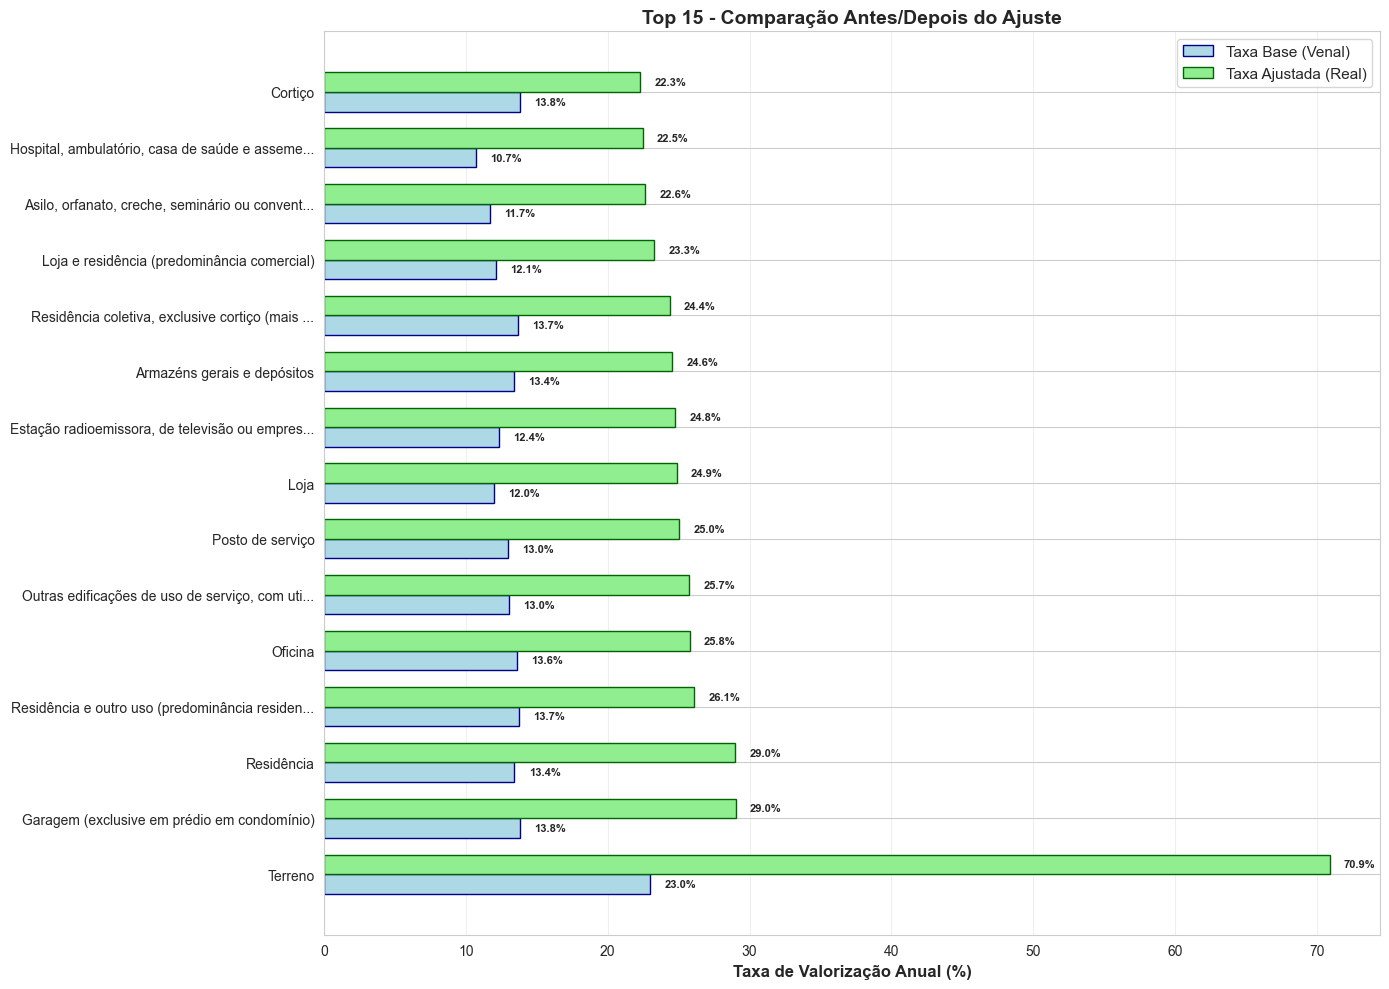


📈 Exibindo gráfico 2: Bottom 15 - Comparação Antes/Depois do Ajuste (ISOLADO)...
💾 Gráfico salvo em: dados_processados/comparacao_bottom15_antes_depois_isolado.png


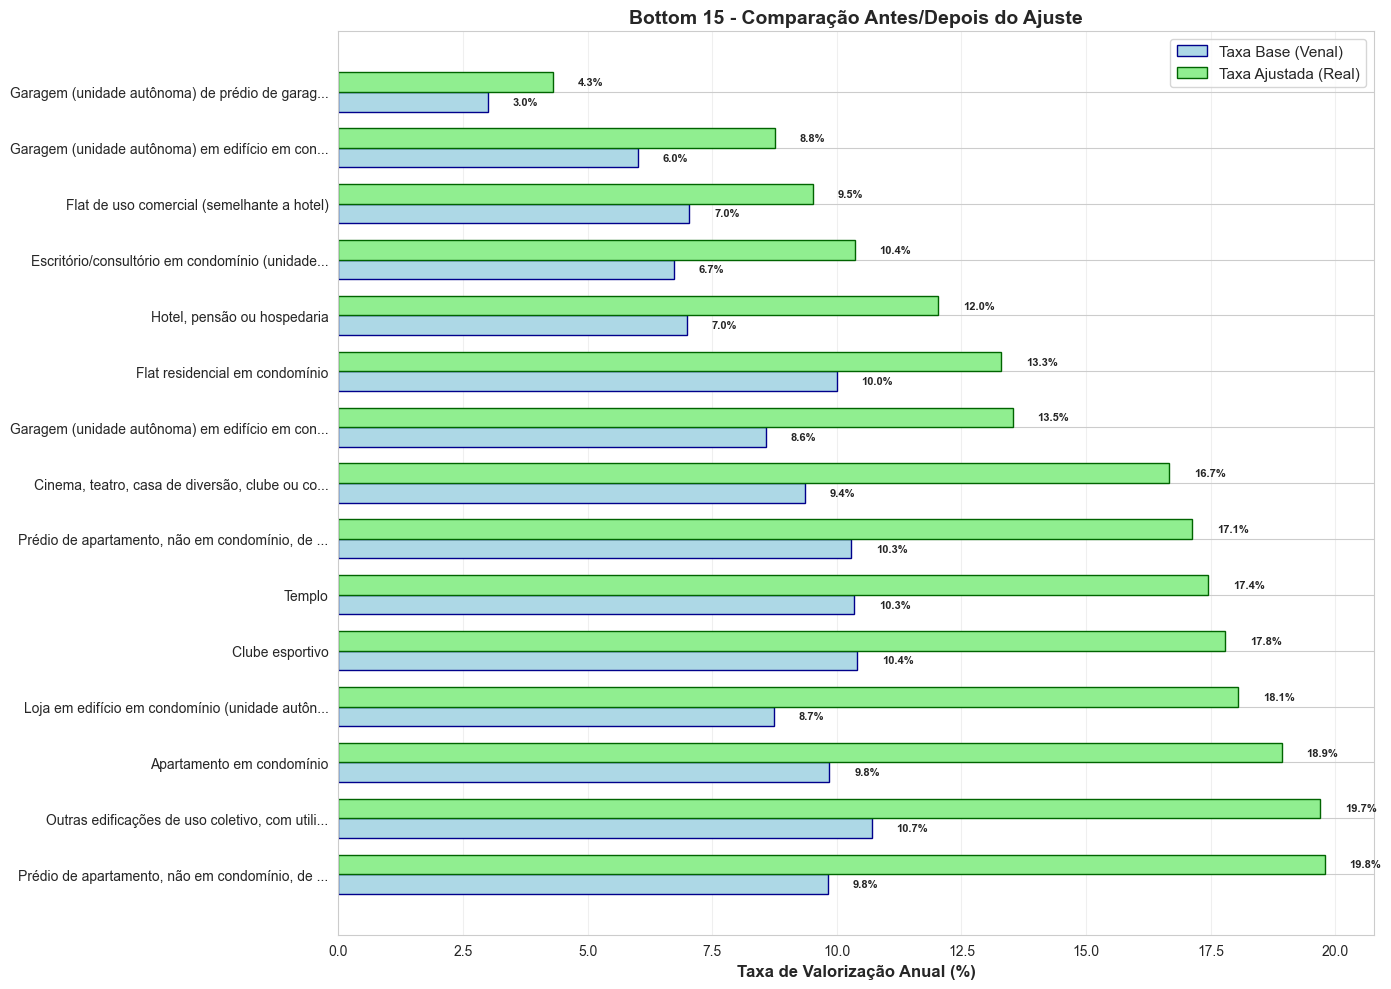


           ✅ GRÁFICOS ISOLADOS - COMPARAÇÃO ANTES/DEPOIS CONCLUÍDOS!            

💾 ARQUIVOS GERADOS (PASSO 4C):
   • dados_processados/comparacao_top15_antes_depois_isolado.png
   • dados_processados/comparacao_bottom15_antes_depois_isolado.png

📊 CARACTERÍSTICAS DOS GRÁFICOS:
   ✅ Gráficos isolados (um por figura)
   ✅ Top 15: Tipos com maior valorização após ajuste
   ✅ Bottom 15: Tipos com menor valorização após ajuste
   ✅ Comparação visual entre Taxa Base (Venal) e Taxa Ajustada (Real)
   ✅ Valores exibidos diretamente nas barras
   ✅ Tamanho otimizado para visualização individual (14x10 polegadas)


In [ ]:
# ============================================================================
# PASSO 4C: GRÁFICOS ISOLADOS - TOP E BOTTOM 15 COMPARAÇÃO ANTES/DEPOIS
# (Parte do PASSO 4: VISUALIZAÇÕES COMPARATIVAS ANTES/DEPOIS)
# ============================================================================

if 'df_comparacao' in locals() and len(df_comparacao) > 0:
    print('\n📊 PASSO 4C: GRÁFICOS ISOLADOS - COMPARAÇÃO ANTES/DEPOIS\n')
    
    # ============================================================================
    # GRÁFICO 1: Top 15 - Comparação Antes/Depois (ISOLADO)
    # ============================================================================
    
    print('\n📈 Exibindo gráfico 1: Top 15 - Comparação Antes/Depois do Ajuste (ISOLADO)...')
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    top_15_comparacao = df_comparacao.head(15)
    
    # Gráfico de barras lado a lado
    x = np.arange(len(top_15_comparacao))
    width = 0.35
    
    bars1 = ax.barh(x - width/2, top_15_comparacao['Taxa_Media'], width, 
                   label='Taxa Base (Venal)', color='lightblue', edgecolor='darkblue', linewidth=1)
    bars2 = ax.barh(x + width/2, top_15_comparacao['Taxa_Ajustada'], width, 
                   label='Taxa Ajustada (Real)', color='lightgreen', edgecolor='darkgreen', linewidth=1)
    
    ax.set_yticks(x)
    ax.set_yticklabels([name[:45] + '...' if len(name) > 45 else name 
                       for name in top_15_comparacao['tipo_uso']], fontsize=10)
    ax.set_xlabel('Taxa de Valorização Anual (%)', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 - Comparação Antes/Depois do Ajuste', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Adicionar valores nas barras
    for i, (idx, row) in enumerate(top_15_comparacao.iterrows()):
        # Valor na barra da taxa base
        ax.text(row['Taxa_Media'] + 1, x[i] - width/2, 
               f'{row["Taxa_Media"]:.1f}%', ha='left', va='center', fontsize=8, fontweight='bold')
        # Valor na barra da taxa ajustada
        ax.text(row['Taxa_Ajustada'] + 1, x[i] + width/2, 
               f'{row["Taxa_Ajustada"]:.1f}%', ha='left', va='center', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dados_processados/comparacao_top15_antes_depois_isolado.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/comparacao_top15_antes_depois_isolado.png')
    plt.show()
    
    # ============================================================================
    # GRÁFICO 2: Bottom 15 - Comparação Antes/Depois (ISOLADO)
    # ============================================================================
    
    print('\n📈 Exibindo gráfico 2: Bottom 15 - Comparação Antes/Depois do Ajuste (ISOLADO)...')
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    bottom_15_comparacao = df_comparacao.tail(15)
    x2 = np.arange(len(bottom_15_comparacao))
    
    bars3 = ax.barh(x2 - width/2, bottom_15_comparacao['Taxa_Media'], width, 
                   label='Taxa Base (Venal)', color='lightblue', edgecolor='darkblue', linewidth=1)
    bars4 = ax.barh(x2 + width/2, bottom_15_comparacao['Taxa_Ajustada'], width, 
                   label='Taxa Ajustada (Real)', color='lightgreen', edgecolor='darkgreen', linewidth=1)
    
    ax.set_yticks(x2)
    ax.set_yticklabels([name[:45] + '...' if len(name) > 45 else name 
                       for name in bottom_15_comparacao['tipo_uso']], fontsize=10)
    ax.set_xlabel('Taxa de Valorização Anual (%)', fontsize=12, fontweight='bold')
    ax.set_title('Bottom 15 - Comparação Antes/Depois do Ajuste', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Adicionar valores nas barras
    for i, (idx, row) in enumerate(bottom_15_comparacao.iterrows()):
        # Valor na barra da taxa base
        ax.text(row['Taxa_Media'] + 0.5, x2[i] - width/2, 
               f'{row["Taxa_Media"]:.1f}%', ha='left', va='center', fontsize=8, fontweight='bold')
        # Valor na barra da taxa ajustada
        ax.text(row['Taxa_Ajustada'] + 0.5, x2[i] + width/2, 
               f'{row["Taxa_Ajustada"]:.1f}%', ha='left', va='center', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dados_processados/comparacao_bottom15_antes_depois_isolado.png', dpi=300, bbox_inches='tight')
    print('💾 Gráfico salvo em: dados_processados/comparacao_bottom15_antes_depois_isolado.png')
    plt.show()
    
    # ============================================================================
    # RESUMO DOS GRÁFICOS ISOLADOS
    # ============================================================================
    
    print('\n' + '='*80)
    print('✅ GRÁFICOS ISOLADOS - COMPARAÇÃO ANTES/DEPOIS CONCLUÍDOS!'.center(80))
    print('='*80)
    
    print(f'\n💾 ARQUIVOS GERADOS (PASSO 4C):')
    print(f'   • dados_processados/comparacao_top15_antes_depois_isolado.png')
    print(f'   • dados_processados/comparacao_bottom15_antes_depois_isolado.png')
    
    print(f'\n📊 CARACTERÍSTICAS DOS GRÁFICOS:')
    print(f'   ✅ Gráficos isolados (um por figura)')
    print(f'   ✅ Top 15: Tipos com maior valorização após ajuste')
    print(f'   ✅ Bottom 15: Tipos com menor valorização após ajuste')
    print(f'   ✅ Comparação visual entre Taxa Base (Venal) e Taxa Ajustada (Real)')
    print(f'   ✅ Valores exibidos diretamente nas barras')
    print(f'   ✅ Tamanho otimizado para visualização individual (14x10 polegadas)')
    
    print('='*80)
else:
    print('\n⚠️ Gráficos isolados não disponíveis.')
    print('   Verifique se df_comparacao está disponível e foi criado corretamente.')

